# **Projeto Final: IA376I – Tópicos em Engenharia de Computação VII**
## **Tópico: Análise de Dados Visual (Visual Analytics)**
**Professora:** Wu, Shin - Ting<br><br>
**Alunos:**<br>
Luiz Roberto Albano Junior RA: 272746<br>
Tárcio Augusto Canhamina Quissanga RA: 214551
<br>
<br>


---




## **1. PROJETO**
Este projeto tem por objetivo realizar uma análise sobre o **nível de evasão dos alunos no IFSP - Instituto Federal de São Paulo** e confirmar se este dado **não é influenciado pela renda familiar** (H0).

**Estátisticas de teste:** nível de evasão de alunos

### **1.1. Base de Dados**
Para construção deste projeto serão analisados os **micro dados** da **Plataforma Nilo Peçanha (PNP)** [1]. Segundo descrição do site:

> "A Plataforma Nilo Peçanha (PNP) é um ambiente virtual de coleta, validação e disseminação das estatísticas oficiais da Rede Federal de Educação Profissional, Científica e Tecnológica (Rede Federal). Tem como objetivo reunir dados relativos ao corpo docente, discente, técnico-administrativo e de gastos financeiros das unidades da Rede Federal, para fins de cálculo dos indicadores de gestão monitorados pela Secretaria de Educação Profissional e Tecnológica do Ministério da Educação (SETEC/MEC)."

Para o projeto selecionamos a base de dados referente aos **microdados de matrículas do ano base de 2020** [2].


In [1]:
import pandas as pd
import numpy as np
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu, chi2_contingency
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
#Download da base de dados
!wget https://github.com/prof-LuizAlbano/feec-analise-dados-visual/raw/main/Tarefas/ProjetoFinal/BaseDados/microdados_matriculas_2021.zip

--2024-06-27 18:09:15--  https://github.com/prof-LuizAlbano/feec-analise-dados-visual/raw/main/Tarefas/ProjetoFinal/BaseDados/microdados_matriculas_2021.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/prof-LuizAlbano/feec-analise-dados-visual/main/Tarefas/ProjetoFinal/BaseDados/microdados_matriculas_2021.zip [following]
--2024-06-27 18:09:15--  https://raw.githubusercontent.com/prof-LuizAlbano/feec-analise-dados-visual/main/Tarefas/ProjetoFinal/BaseDados/microdados_matriculas_2021.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56492054 (54M) [application/zip]
Saving to: ‘microdados_matr

In [3]:
#Descompactação do arquivo
!unzip microdados_matriculas_2021.zip

Archive:  microdados_matriculas_2021.zip
  inflating: microdados_matriculas_2021.csv  


In [4]:
#Leitura da Base de dados dos Microdados Matriculados até 2019, fornecido pelo MEC

df = pd.read_csv('microdados_matriculas_2021.csv', sep=';', low_memory=False)
#df.head()

#Conhecendo a forma (tamanho da dataset), vendo o volume de dados com as quais estaremos trabalhando para a nossa análise e as colunas todas para selecionarmos as que interessam para o nosso estudo
df.shape
#df.columns

(1507476, 54)

In [5]:
#Fazendo uma extração do Dataset geral somente as colunas que nos dariam os dados que interessariam para o nosso estudo
studyColumns = ['Cor/Raça', 'Eixo Tecnológico', 'Faixa Etária', 'Fator Esforco Curso', 'Fonte de Financiamento', 'Idade', 'Instituição', 'Modalidade de Ensino', 'Código do Município com DV', 'Nome de Curso', 'Região', 'Renda Familiar', 'Sexo', 'Situação de Matrícula', 'Tipo de Curso', 'Turno', 'UF', 'Unidade de Ensino']
df = df[studyColumns]
df.head()
df.shape

(1507476, 18)

### **2. LIMPEZA E PREPARAÇÃO DOS DADOS**

In [6]:
# 2.1. Verificando dados em falta
print(df.isnull().sum())

Cor/Raça                         0
Eixo Tecnológico                 0
Faixa Etária                     0
Fator Esforco Curso              0
Fonte de Financiamento           0
Idade                         3784
Instituição                      0
Modalidade de Ensino             0
Código do Município com DV       0
Nome de Curso                    0
Região                           0
Renda Familiar                   0
Sexo                             0
Situação de Matrícula            0
Tipo de Curso                    0
Turno                            0
UF                               0
Unidade de Ensino                0
dtype: int64


In [7]:
# 2.2. Removendo linhas com dados em falta
df_cleaned = df.dropna()
df_cleaned.shape

(1503692, 18)

In [8]:
# 2.3. Converter tipo de dado
df_cleaned['Idade'] = df_cleaned['Idade'].astype(int)

<ipython-input-8-c4e19065277c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:
#Verificando os dados

#Renda Familiar
print(df_cleaned['Renda Familiar'].unique())

['1<RFP<=1,5' 'RFP>3,5' '0<RFP<=0,5' '1,5<RFP<=2,5' '2,5<RFP<=3,5'
 'Não declarada' '0,5<RFP<=1']


In [10]:
#Situação de Matrícula
situacoes_matricula = df_cleaned['Situação de Matrícula'].unique()
situacoes_matricula

array(['Integralizada', 'Concluída', 'Abandono', 'Em curso', 'Desligada',
       'Cancelada', 'Transf. externa', 'Transf. interna', 'Reprovado'],
      dtype=object)

In [11]:
#Instituições
instituicoes = df_cleaned['Instituição'].unique()
instituicoes

array(['IFG', 'IF GOIANO', 'IFMT', 'IFB', 'IFMS', 'IFPB', 'UFPB - CAVN',
       'IFS', 'IFPE', 'IFBA', 'IFMA', 'IFCE', 'IFAL', 'IF BAIANO',
       'UFCG - ETSC', 'IFRN', 'IF SERTÃO-PE', 'IFPI', 'UFPB - ETS',
       'ESUFRN', 'UFPI - CABJ', 'UFMA - COLUN', 'IFTO', 'IFRO', 'IFAM',
       'IFAP', 'IFRR', 'IFAC', 'IFPA', 'EMUFPA', 'IFMG', 'IFES', 'IFF',
       'IFSP', 'CEFET-MG', 'CEFET-RJ', 'IF SUDESTE MG', 'IFSULDEMINAS',
       'IFRJ', 'IFNMG', 'CPII', 'IFTM', 'UFU - ESTES', 'UFTM - CEFORES',
       'UFV - CEDAF', 'IF FARROUPILHA', 'IFSUL', 'IFRS', 'IFC', 'IFSC',
       'IFPR', 'UFSM - POLITÉCNICO', 'UFRPE - CODAI', 'UFRN - EAJ',
       'UFSM - CTISM', 'UFPI - CTF', 'UFRN - MÚSICA', 'ETDUFPA',
       'UFMG - TU', 'UFRR - EAGRO', 'UFMG - COLTEC', 'UFPI - CAT',
       'UFAL - ETA', 'UFRRJ - CTUR'], dtype=object)

In [12]:
#Tipo de Curso
tipos_cursos = df_cleaned['Tipo de Curso'].unique()
tipos_cursos

array(['Técnico', 'Bacharelado', 'Tecnologia',
       'Qualificação Profissional (FIC)', 'Especialização (Lato Sensu)',
       'Mestrado Profissional', 'Mestrado', 'Ensino Fundamental II',
       'Ensino Médio', 'Licenciatura', 'Ensino Fundamental I',
       'Doutorado', 'Educação Infantil'], dtype=object)

In [13]:
#Faixa Etária
faixa_etaria = df_cleaned['Faixa Etária'].unique()
faixa_etaria

array(['15 a 19 anos', '20 a 24 anos', '25 a 29 anos', '30 a 34 anos',
       '35 a 39 anos', '50 a 54 anos', '45 a 49 anos', '40 a 44 anos',
       'Maior de 60 anos', '55 a 59 anos', 'Menor de 14 anos', 'S/I'],
      dtype=object)

In [14]:
#Cor/Raça
cor_raca = df_cleaned['Cor/Raça'].unique()
cor_raca

array(['BRANCA', 'INDÍGENA', 'NÃO DECLARADA', 'PARDA', 'PRETA', 'AMARELA'],
      dtype=object)

In [15]:
#Sexo
sexo = df_cleaned['Sexo'].unique()
sexo

array(['F', 'M'], dtype=object)

### **3. FILTROS E ANÁLISES INICIAIS DOS DADOS**

#### **3.1. ANÁLISE SOBRE OS DADOS GERAIS**

No dataset estão contidos dados de toda rede federal, portanto para cumprirmos com o objetivo deste projeto iremos filtrar apenas os registros que se referem ao **IFSP - Instituto Federal de São Paulo**.


In [16]:
df_filtered = df_cleaned[ (df_cleaned['Instituição'] == "IFSP") ]
#df_filtered.head()
df_filtered.shape

(56473, 18)

Incialmente, vamos analisar alguns quantificadores por variáveis, para entender os dados do dataset.

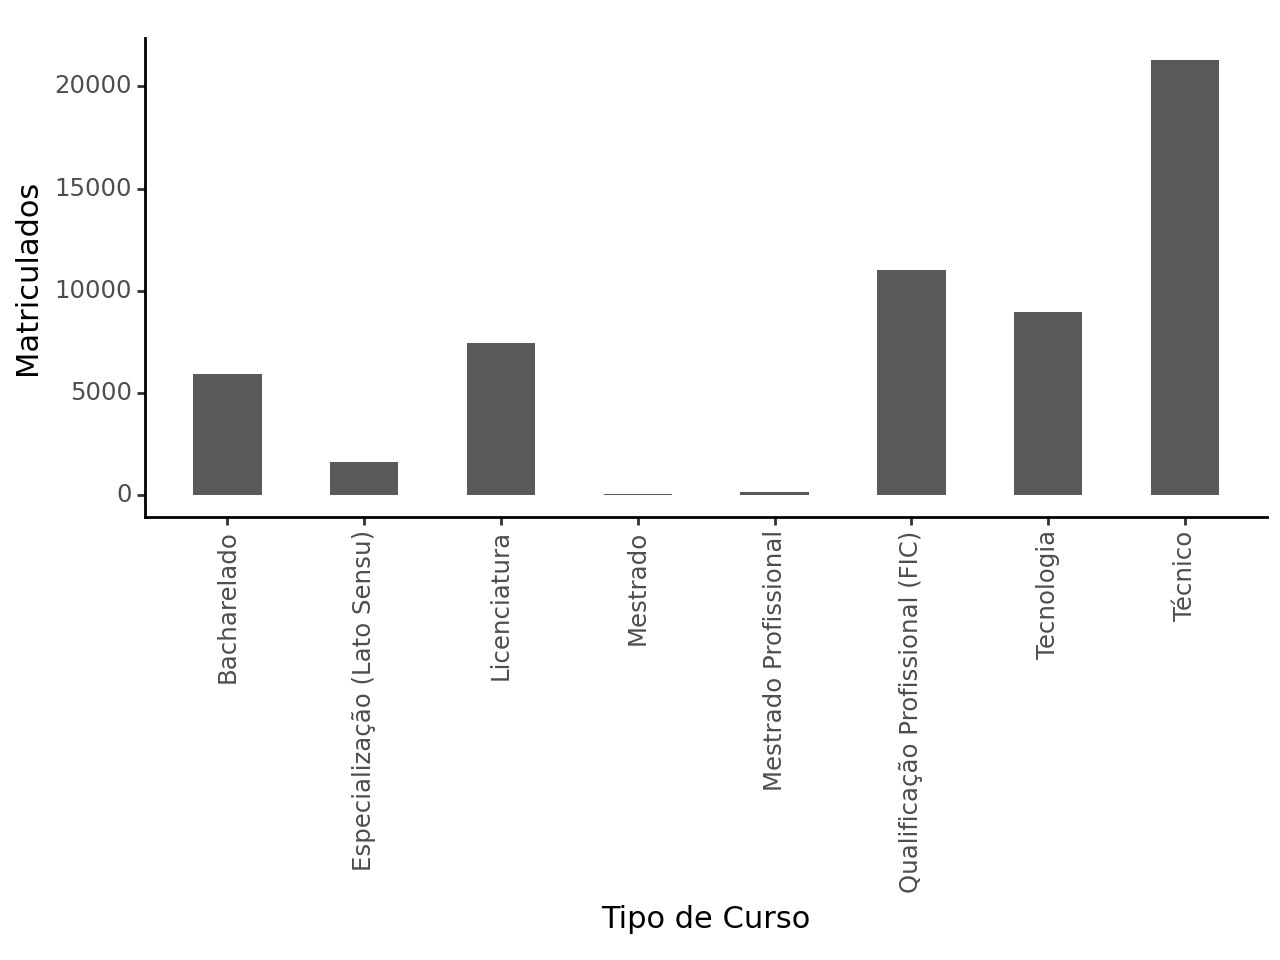

<Figure Size: (640 x 480)>

In [17]:
#Matrículas por tipo de curso

(
    ggplot(df_filtered, aes(x="Tipo de Curso"))
    + geom_histogram(binwidth=0.5, show_legend=True)
    + labs(y="Matriculados")
    + theme_classic()
    + theme(axis_text_x = element_text(angle=90))
)

Por serem cursos de formação específicos e além do ciclo de formação de um estudante, vamos filtrar o dataset sem os dados dos cursos: Especialização, Mestrado, Mestrado Profissional e Qualificação Profissional (FIC).

In [18]:
df_filtered = df_filtered[ ~df_filtered['Tipo de Curso'].isin(['Mestrado', 'Mestrado Profissional', 'Especialização (Lato Sensu)', 'Qualificação Profissional (FIC)']) ]
df_filtered.shape

(43620, 18)

<ipython-input-19-f525ba1a46f4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


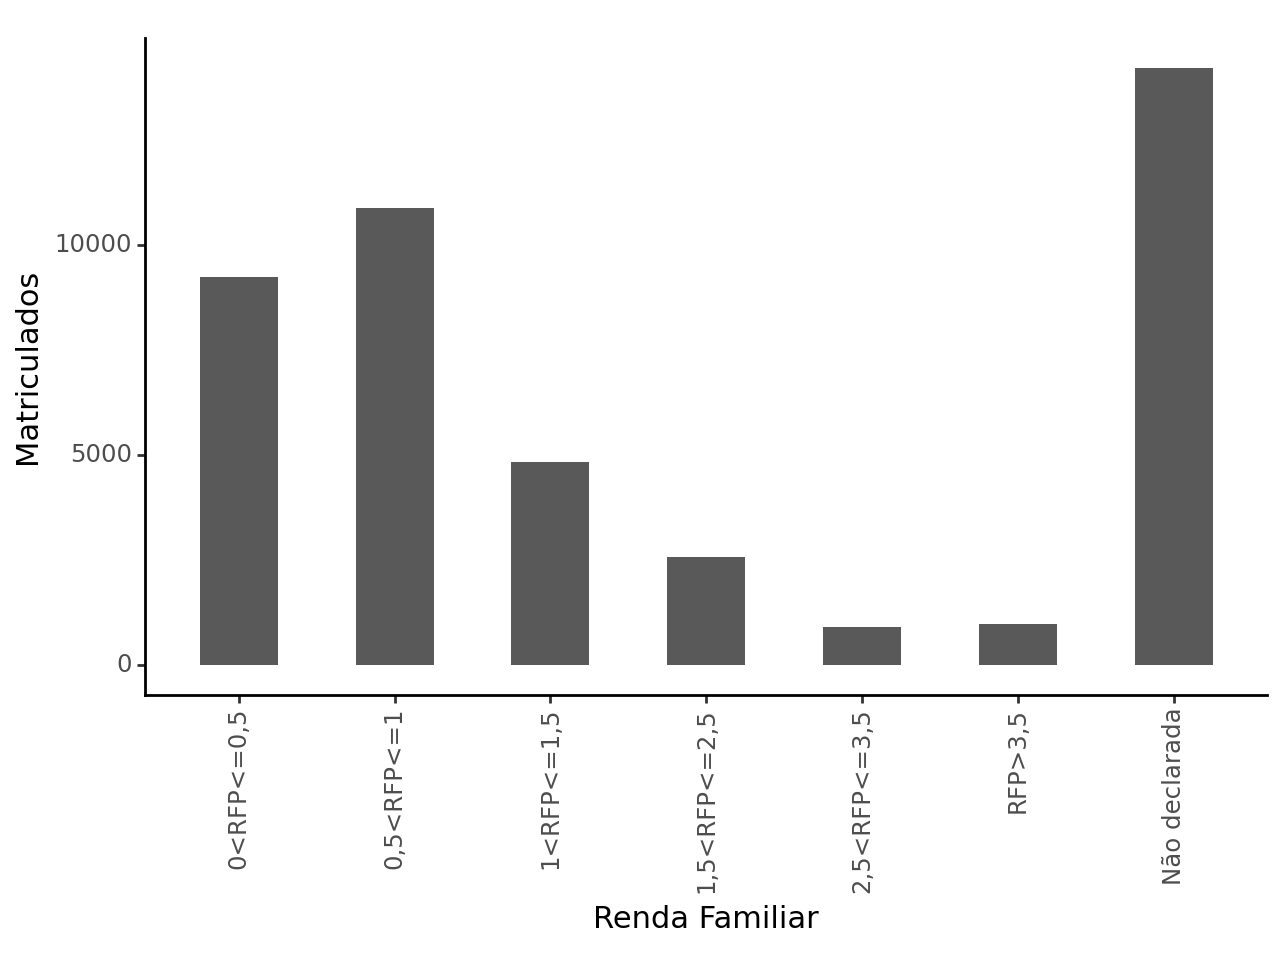

<Figure Size: (640 x 480)>

In [19]:
#Renda Familiar

renda_ordenada = ['0<RFP<=0,5', '0,5<RFP<=1', '1<RFP<=1,5', '1,5<RFP<=2,5', '2,5<RFP<=3,5', 'RFP>3,5', 'Não declarada']
df_filtered["Renda Familiar"] = df_filtered["Renda Familiar"].astype('category').cat.reorder_categories(renda_ordenada, ordered=True)

(
    ggplot(df_filtered, aes(x="Renda Familiar"))
    + geom_histogram(binwidth=0.5, show_legend=True)
    + labs(y="Matriculados")
    + theme_classic()
    + theme(axis_text_x = element_text(angle=90))
)

Notamos que o maior número de matriculados estão nas duas primeiras faixas de RFP.<br>
Para nossos estudos teremos que remover os registros cujas matrículas não tenham declarada sua renda familiar.

In [20]:
df_filtered = df_filtered[ ~df_filtered['Renda Familiar'].isin(['Não declarada']) ]
df_filtered.shape

(29406, 18)

**Renda Familiar - Legenda**<br>
RFP: Renda familiar per capita. É um valor utilizado pelo governo para comprovação de participação dos programas do governo federal. É calculado com base na soma da renda de todos os moradores de uma residência, dividida pelo número total de pessoas que vivem sob manutenção desta renda total.

Os agrupamentos utilizados no dataset são:

RFP            | Descrição
---------------|-----------
**0<RFP<=0,5** | renda entre R\$ 0,00 e R\$ 500,00 por pessoa
**0,5<RFP<=1** | renda entre R\$ 500,00 e R\$ 1.000,00 por pessoa
**1<RFP<=1,5** | renda entre R\$ 1.000,00 e R\$ 1.500,00 por pessoa
**1,5<RFP<=2,5** | renda entre R\$ 1.500,00 e R\$ 2.500,00 por pessoa
**2,5<RFP<=3,5** | renda entre R\$ 2.500,00 e R\$ 3.500,00 por pessoa
**RFP>3,5** | renda acima de R\$ 3.500,00 por pessoa

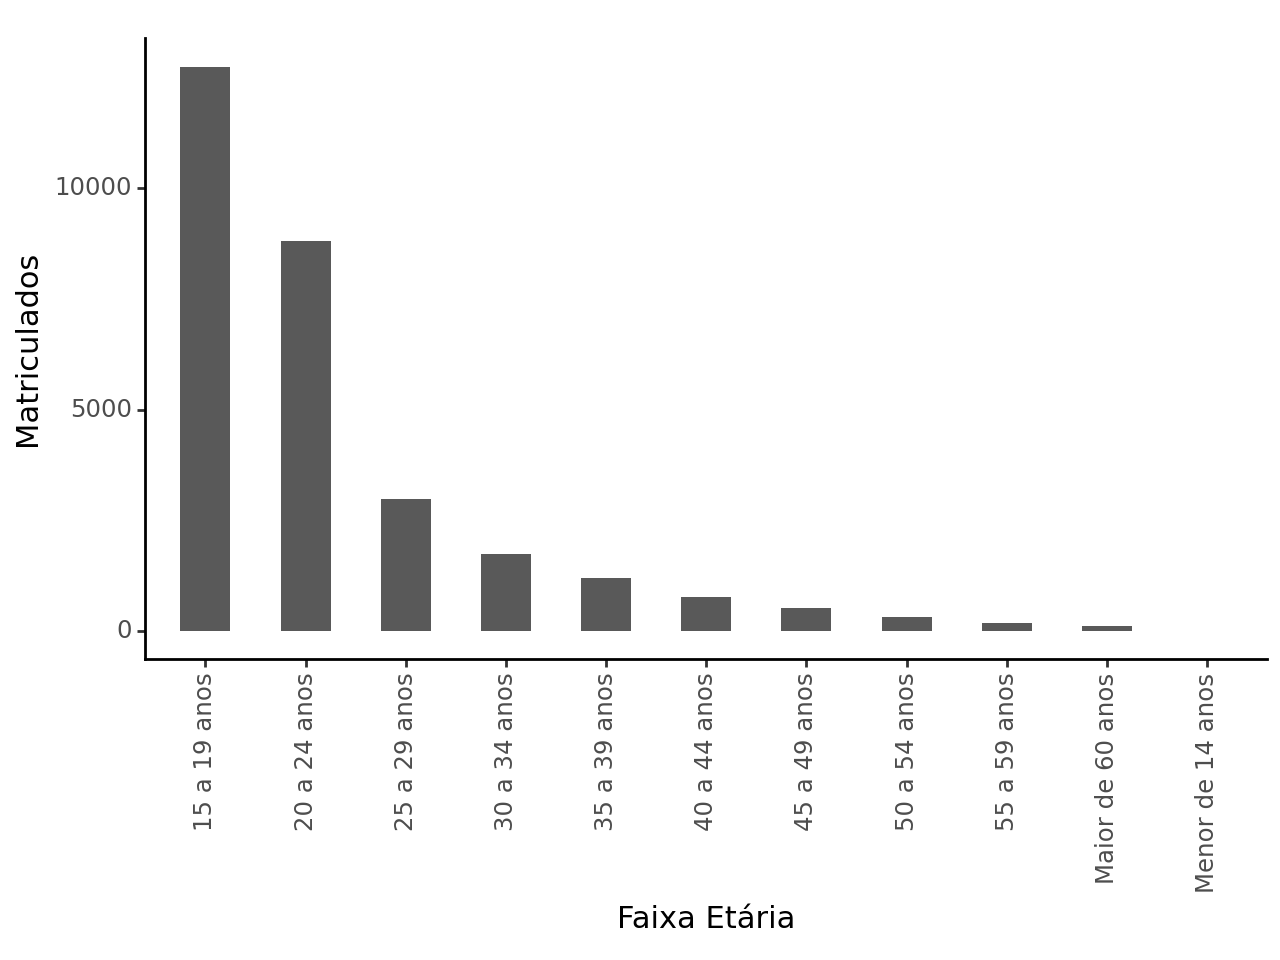

<Figure Size: (640 x 480)>

In [21]:
#Faixa Etária

(
    ggplot(df_filtered, aes(x="Faixa Etária"))
    + geom_histogram(binwidth=0.5, show_legend=True)
    + labs(y="Matriculados")
    + theme_classic()
    + theme(axis_text_x = element_text(angle=90))
)

No gráfico acima podemos notar que o maior número de matriculados estão em faixas de idades que provavelmente estão fora do mercado de trabalho ou no início de suas carreiras e podem ter uma dependência maior da renda da família.

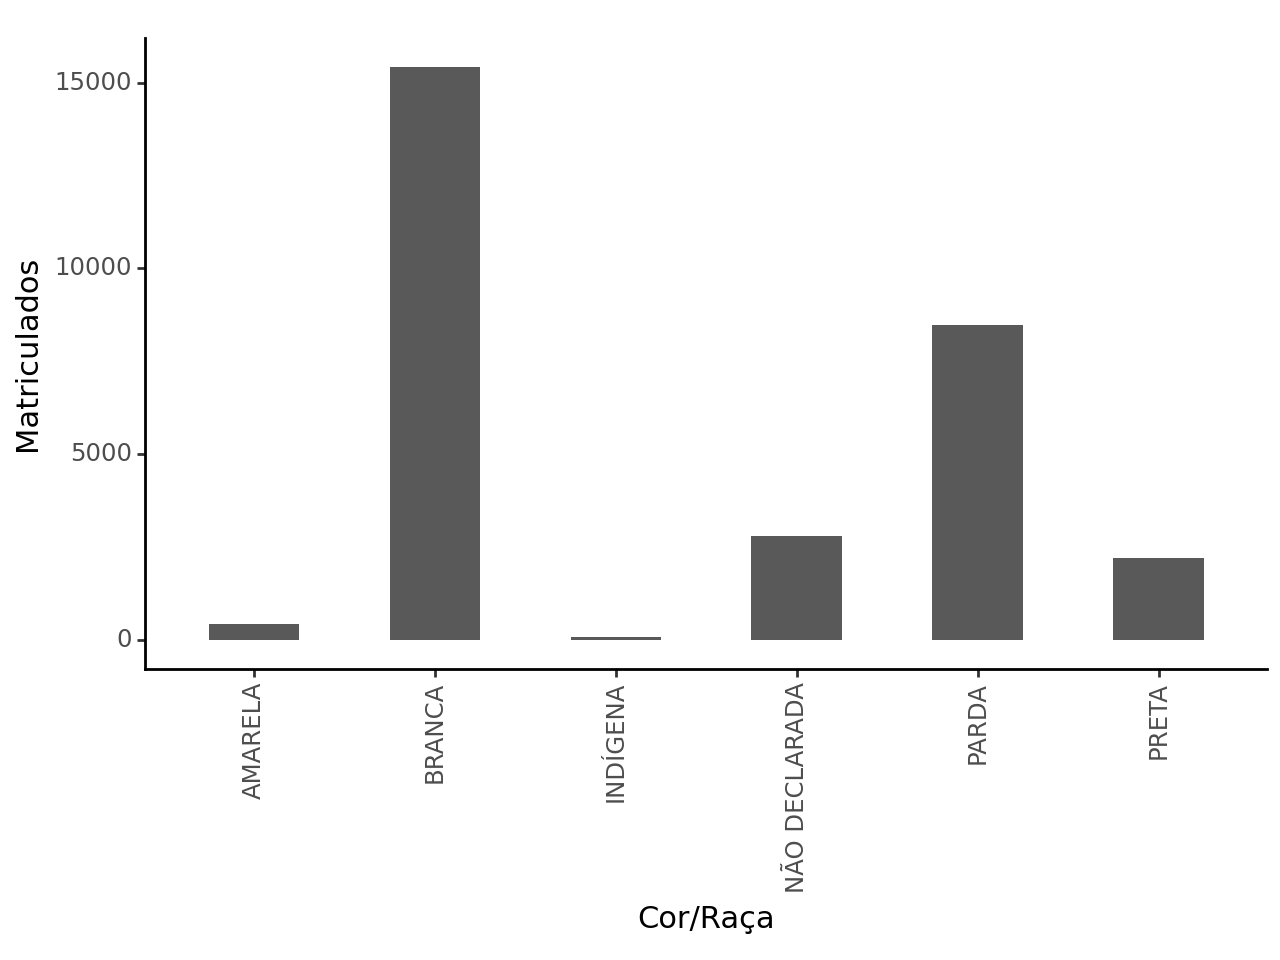

<Figure Size: (640 x 480)>

In [22]:
#Cor/Raça

(
    ggplot(df_filtered, aes(x="Cor/Raça"))
    + geom_histogram(binwidth=0.5, show_legend=True)
    + labs(y="Matriculados")
    + theme_classic()
    + theme(axis_text_x = element_text(angle=90))
)

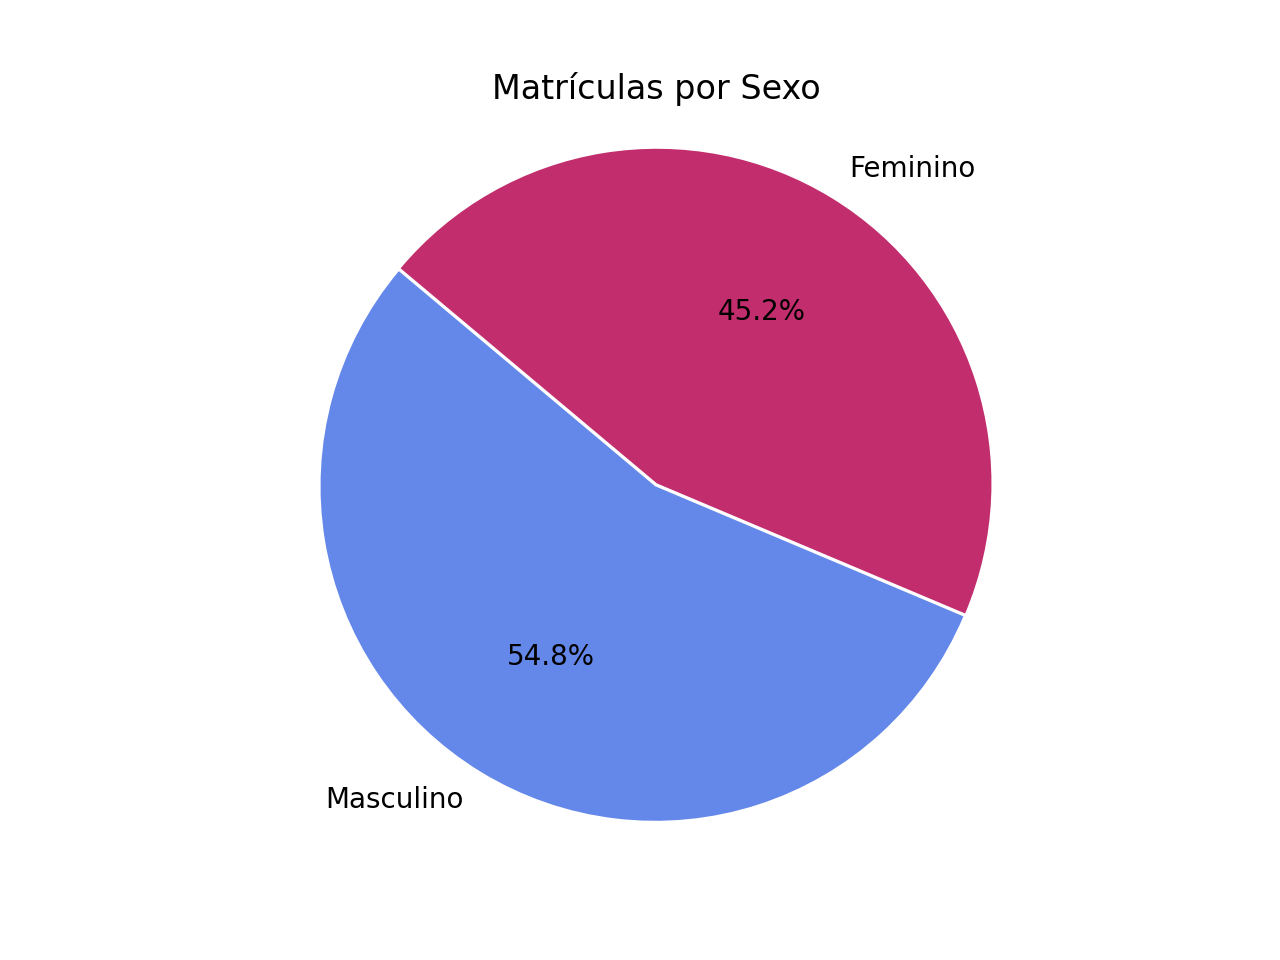

In [23]:
#Sexo

gender = df_filtered["Sexo"].value_counts()

# Customize colors and other settings
colors = ['#6488EA','#c22d6d']
explode = (0.01,0) # Explode 1st slice
plt.pie(gender, explode = explode, labels = ["Masculino", "Feminino"], colors = colors, autopct = '%1.1f%%', shadow = False, startangle = 140)
plt.title('Matrículas por Sexo')
plt.axis('equal')
plt.show()

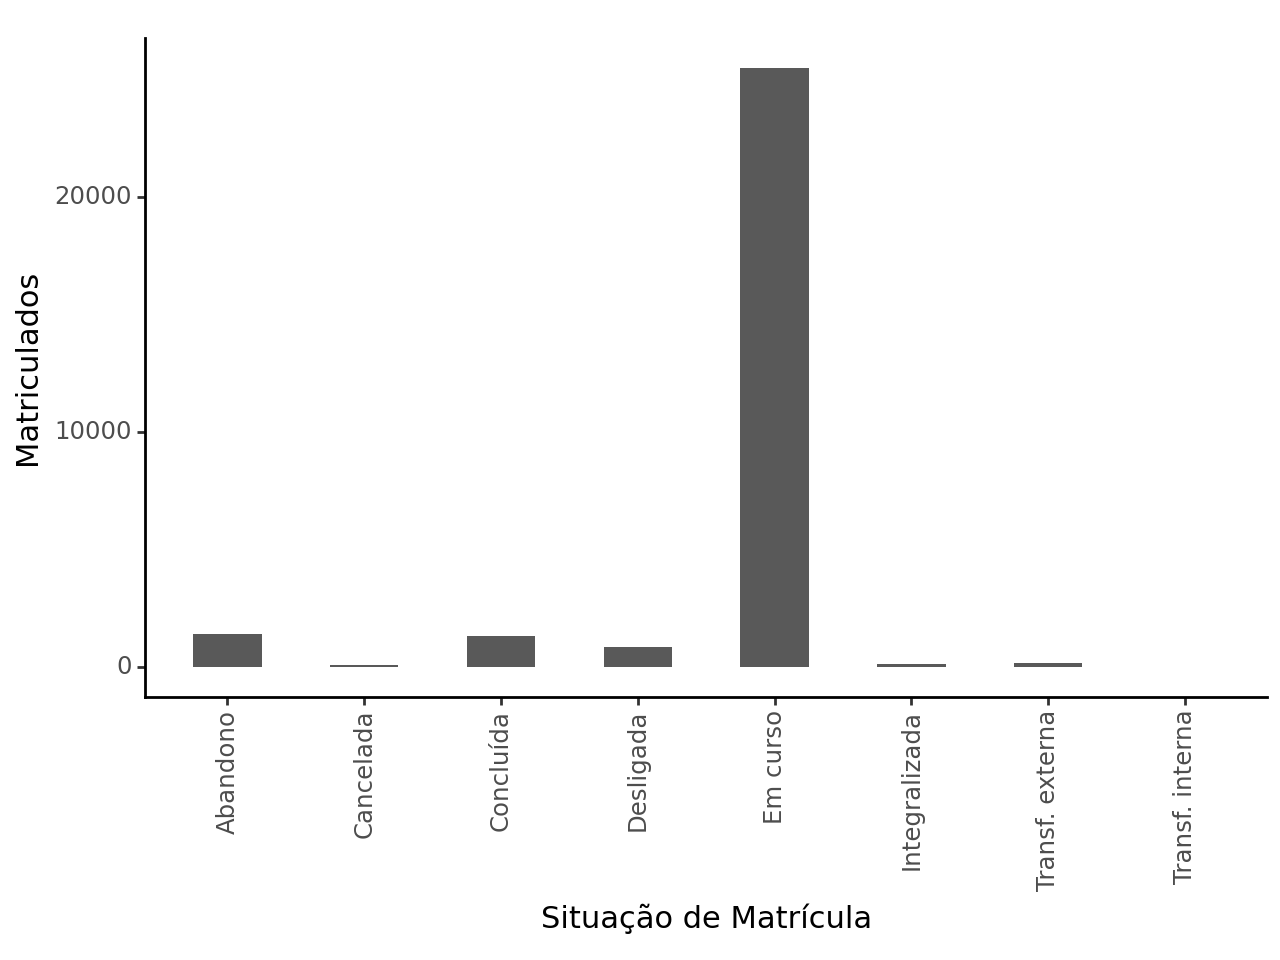

<Figure Size: (640 x 480)>

In [24]:
#Situaçao de Matricula

(
    ggplot(df_filtered, aes(x="Situação de Matrícula"))
    + geom_histogram(binwidth=0.5, show_legend=True)
    + labs(y="Matriculados")
    + theme_classic()
    + theme(axis_text_x = element_text(angle=90))
)

E por fim, os totais por Situação de Matrícula, onde podemos notar que o Abandono é a maior razão entre as situações que impedem os alunos de não concluirem um curso (Abandono, Cancelamento, Desligamento, Reprovação).

In [25]:
df_evaded = df_filtered[ df_filtered['Situação de Matrícula'].isin(['Abandono', 'Cancelada', 'Desligada']) ]
df_evaded.shape

(2301, 18)

In [26]:
df_concluded = df_filtered[ df_filtered['Situação de Matrícula'].isin(['Concluída']) ]
df_concluded.shape

(1326, 18)

#### **3.2. ANÁLISE SOBRE OS DADOS DE EVASÃO**

**Evasão por: Tipo de Curso**

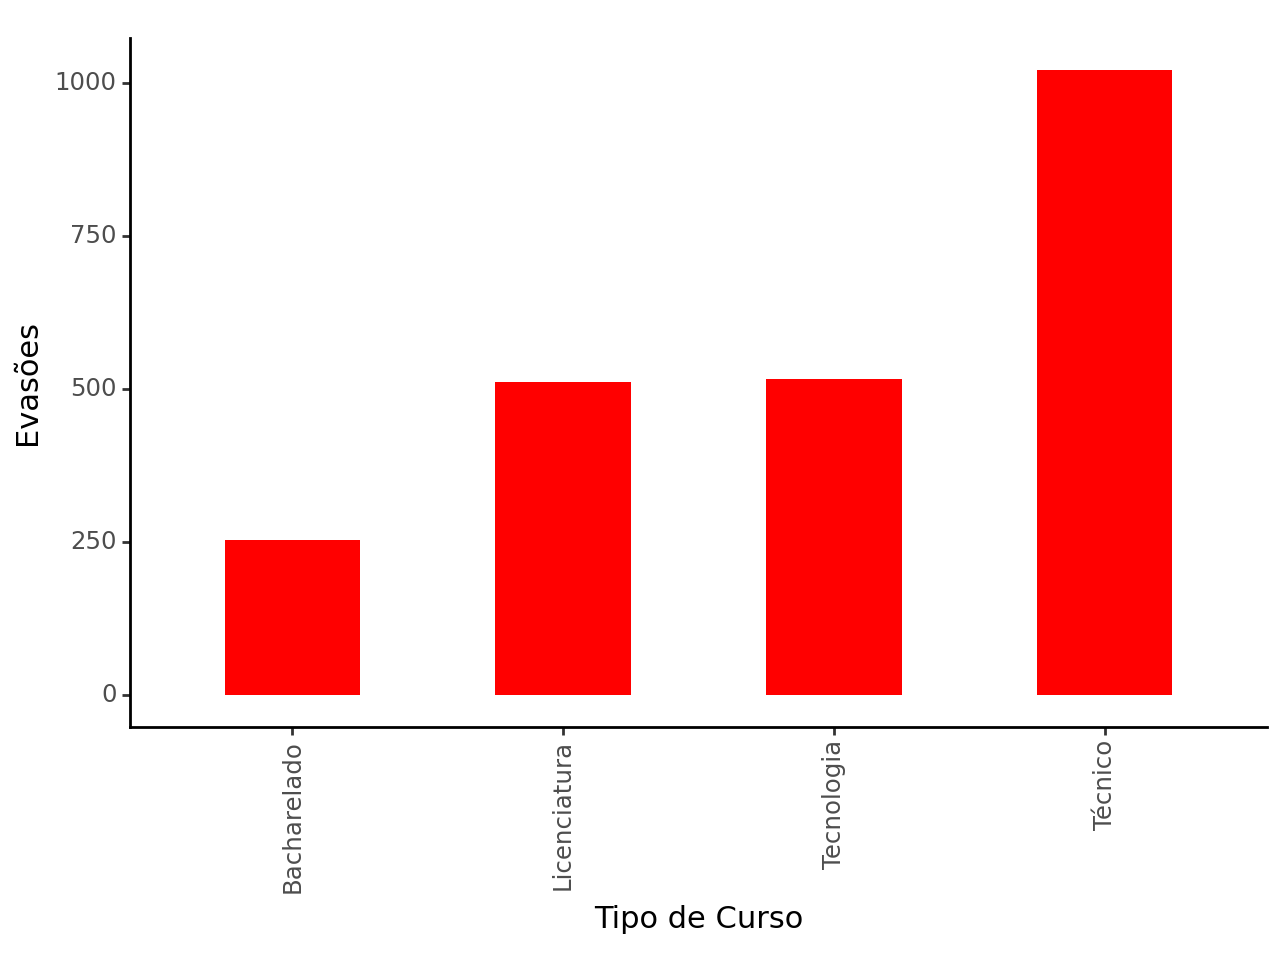

<Figure Size: (640 x 480)>

In [27]:
#Matrículas por tipo de curso

(
    ggplot(df_evaded, aes(x="Tipo de Curso"))
    + geom_histogram(binwidth=0.5, show_legend=True, fill="red")
    + labs(y="Evasões")
    + theme_classic()
    + theme(axis_text_x = element_text(angle=90))
)

**Evasão por: Renda Familiar**

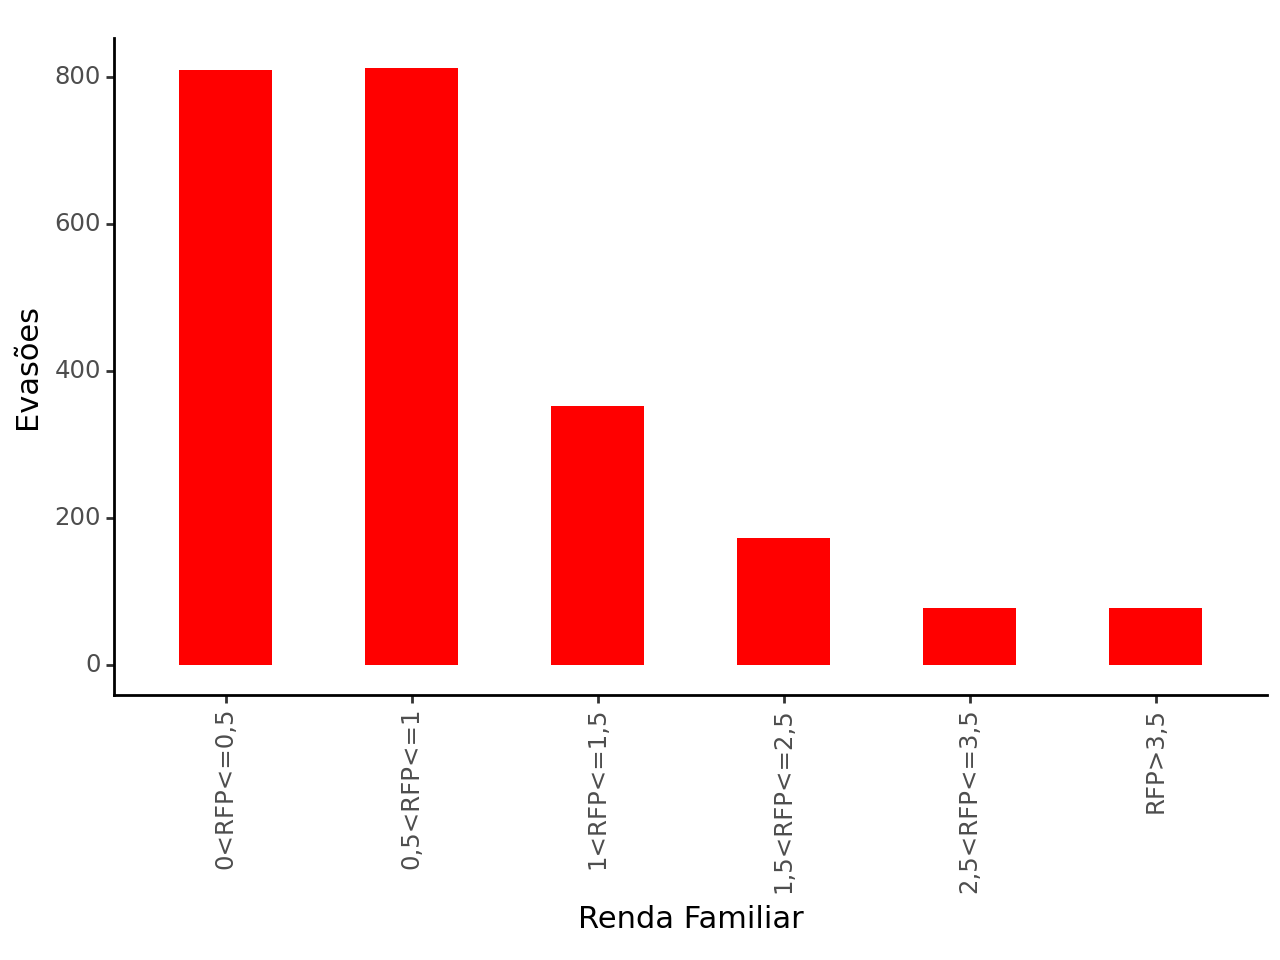

<Figure Size: (640 x 480)>

In [28]:
#Renda Familiar

(
    ggplot(df_evaded, aes(x="Renda Familiar"))
    + geom_histogram(binwidth=0.5, show_legend=True, fill="red")
    + labs(y="Evasões")
    + theme_classic()
    + theme(axis_text_x = element_text(angle=90))
)

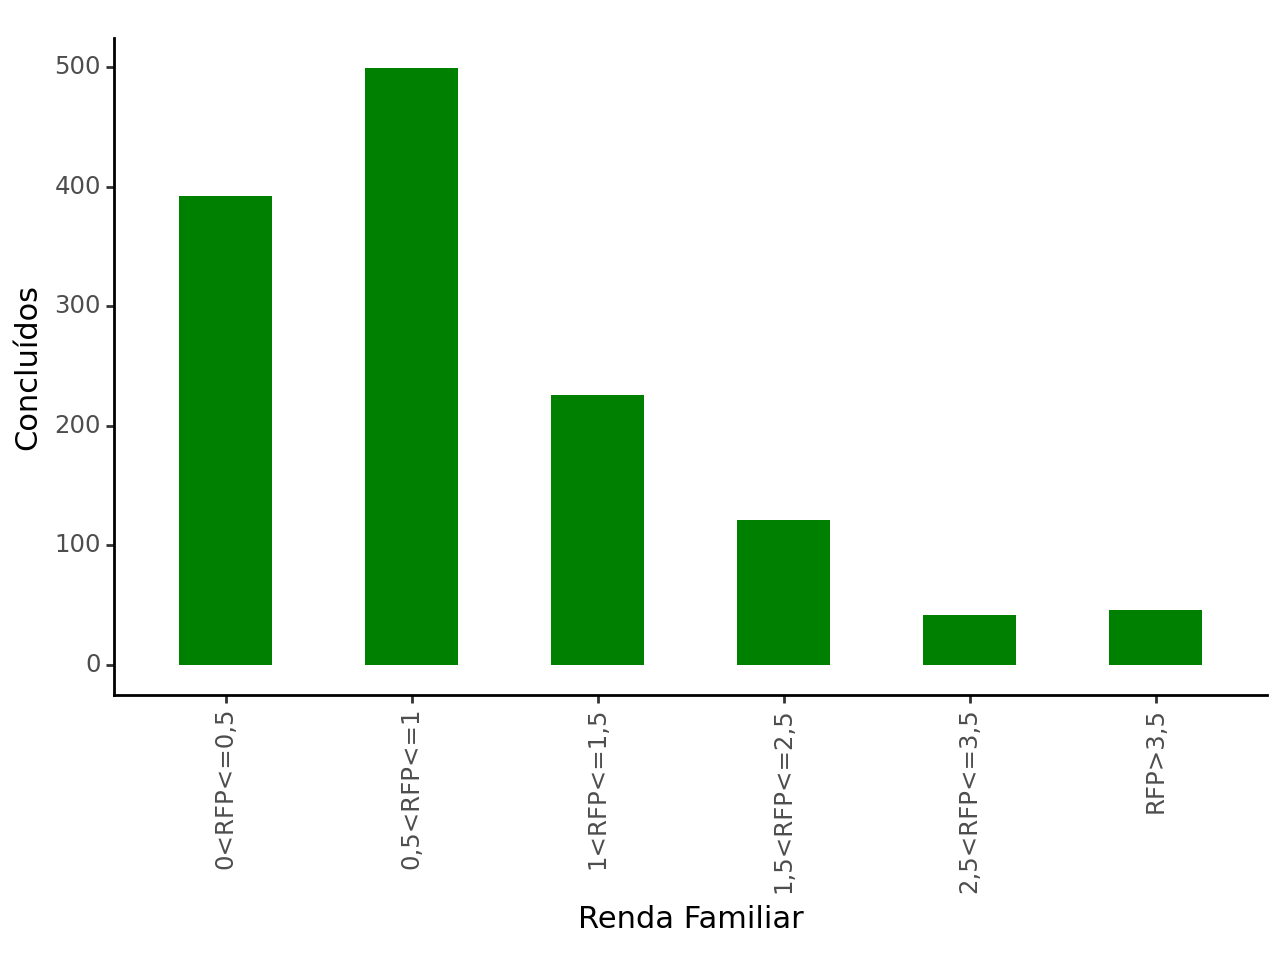

<Figure Size: (640 x 480)>

In [29]:
#Renda Familiar - dos alunos Concluintes

(
    ggplot(df_concluded, aes(x="Renda Familiar"))
    + geom_histogram(binwidth=0.5, show_legend=True, fill="green")
    + labs(y="Concluídos")
    + theme_classic()
    + theme(axis_text_x = element_text(angle=90))
)

**Evasão por: Faixa Etária**

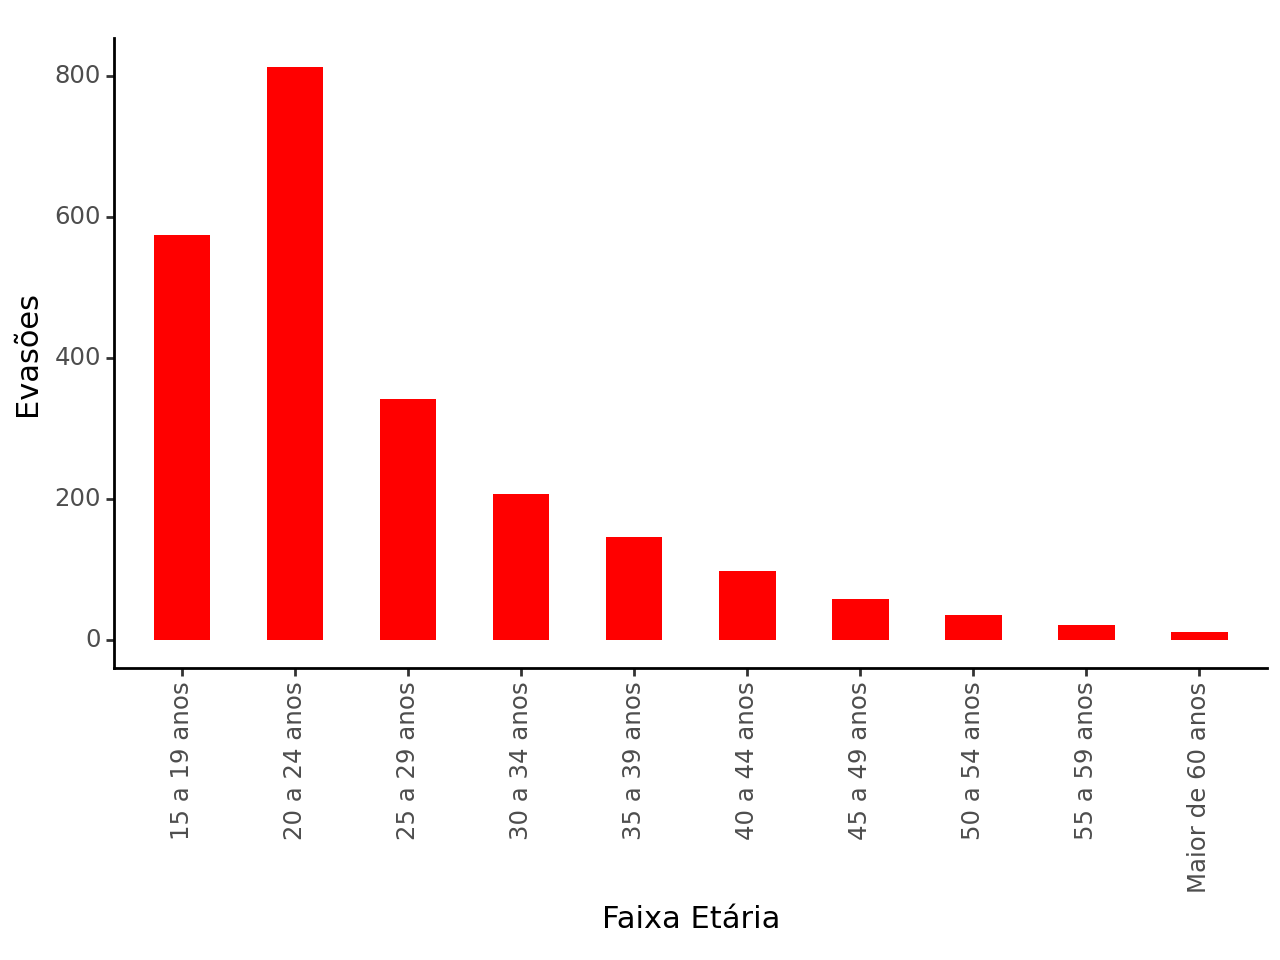

<Figure Size: (640 x 480)>

In [30]:
#Faixa Etária

(
    ggplot(df_evaded, aes(x="Faixa Etária"))
    + geom_histogram(binwidth=0.5, show_legend=True, fill="red")
    + labs(y="Evasões")
    + theme_classic()
    + theme(axis_text_x = element_text(angle=90))
)

**Evasão por: Cor/Raça**

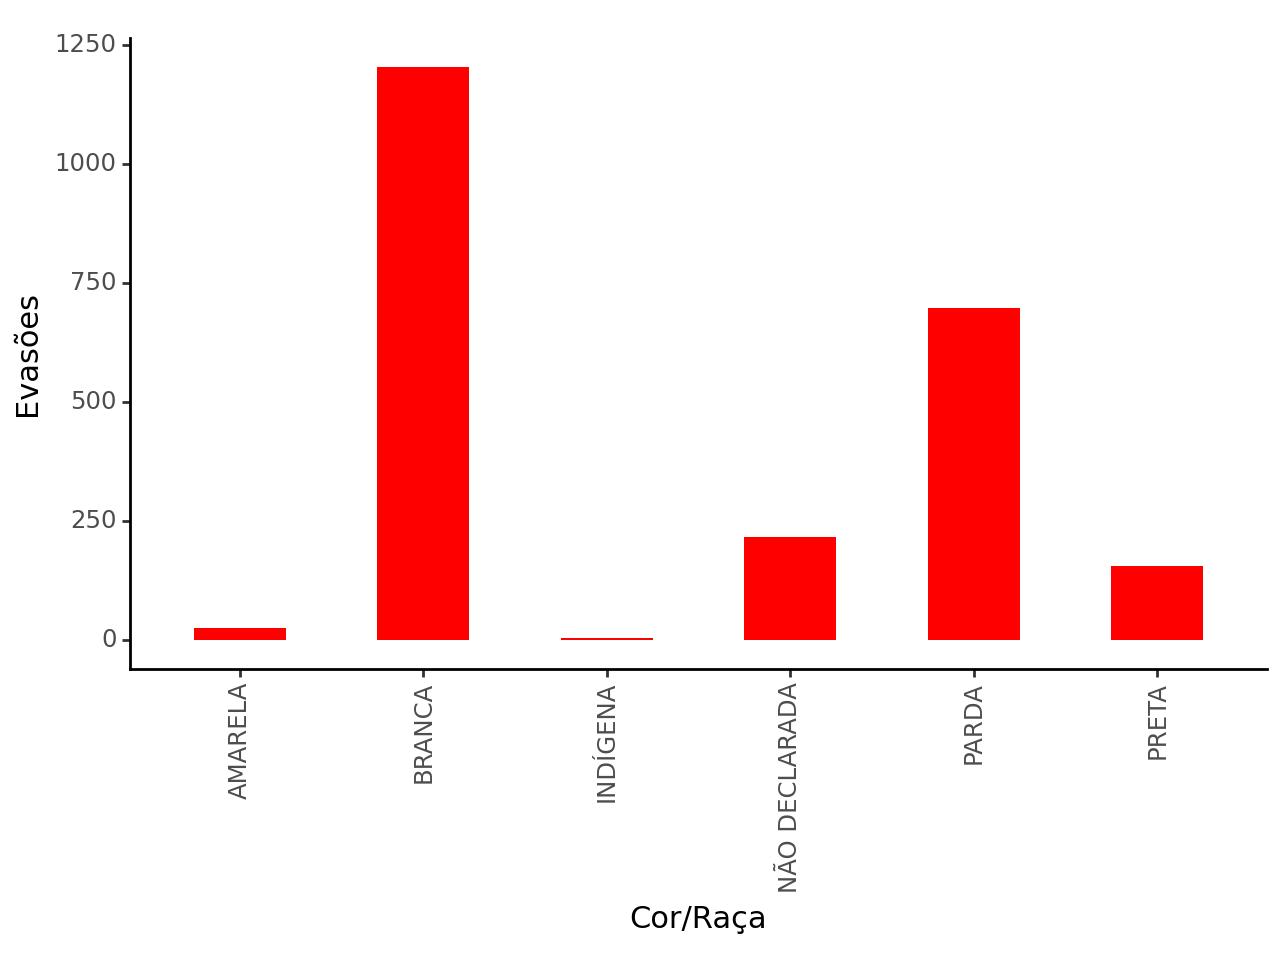

<Figure Size: (640 x 480)>

In [31]:
#Cor/Raça

(
    ggplot(df_evaded, aes(x="Cor/Raça"))
    + geom_histogram(binwidth=0.5, show_legend=True, fill="red")
    + labs(y="Evasões")
    + theme_classic()
    + theme(axis_text_x = element_text(angle=90))
)

**Evasão por: Sexo**

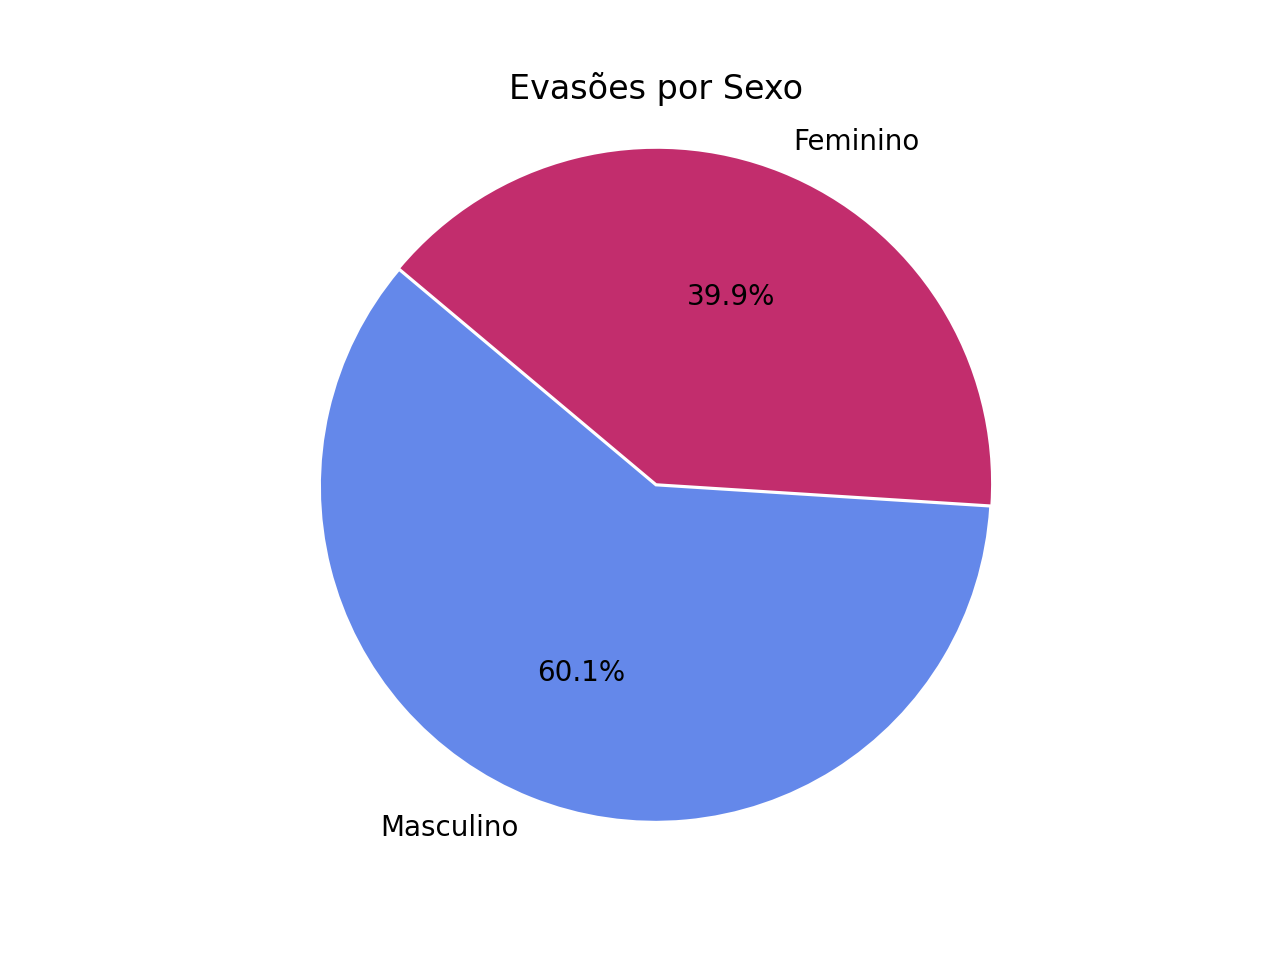

In [32]:
#Sexo

gender = df_evaded["Sexo"].value_counts()

# Customize colors and other settings
colors = ['#6488EA','#c22d6d']
explode = (0.01,0) # Explode 1st slice
plt.pie(gender, explode = explode, labels = ["Masculino", "Feminino"], colors = colors, autopct = '%1.1f%%', shadow = False, startangle = 140)
plt.title('Evasões por Sexo')
plt.axis('equal')
plt.show()

#### **3.3. COMPARATIVO ENTRE DADOS DE EVASÃO E DADOS GERAIS DO IFSP**

**Matrículas/Evasão por: Tipo de Curso**

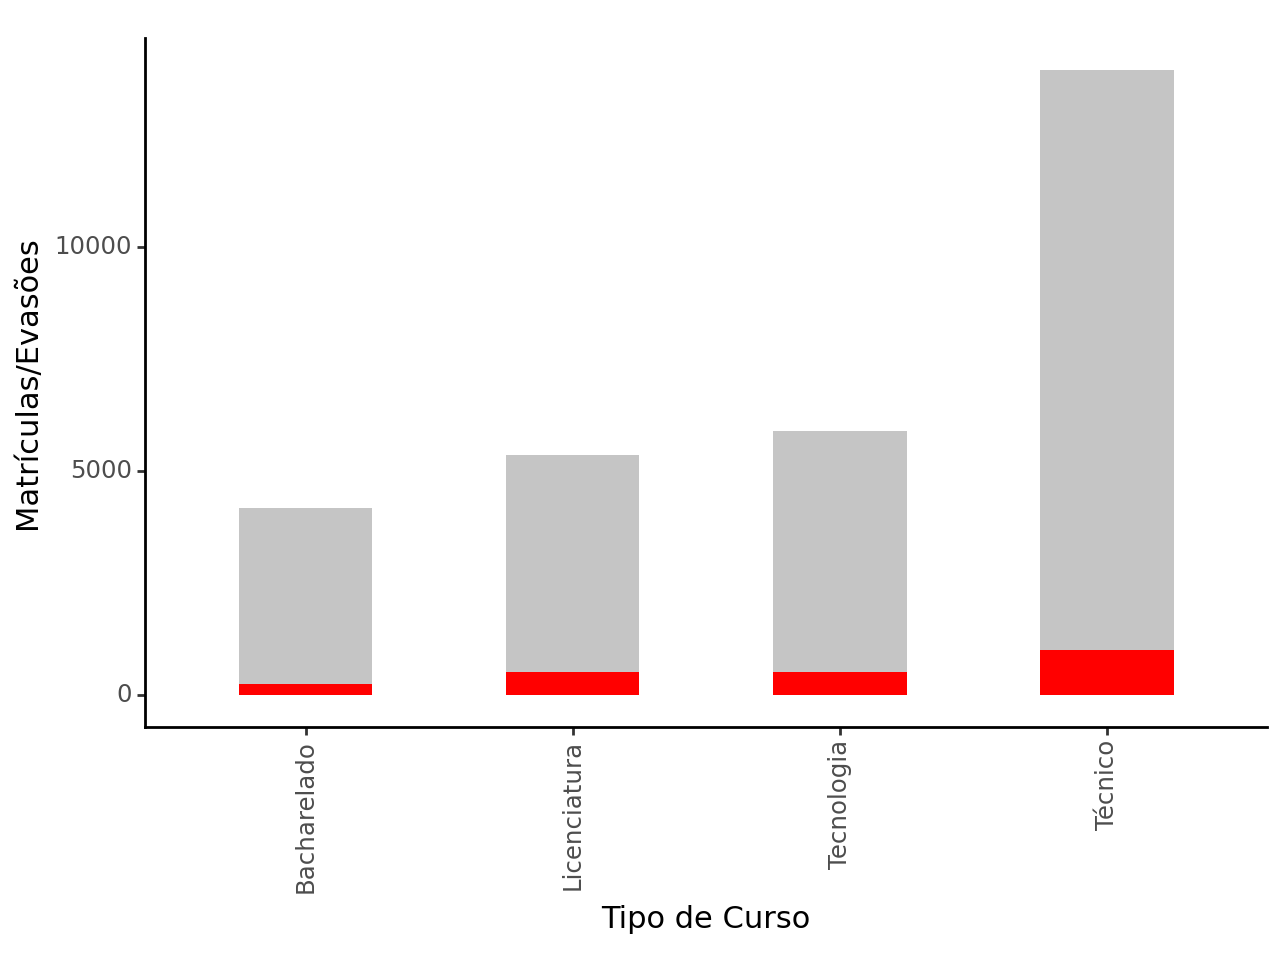

<Figure Size: (640 x 480)>

In [33]:
#Matrículas por tipo de curso

(
    ggplot(df_evaded, aes(x="Tipo de Curso"))
    + geom_histogram(data=df_filtered, mapping=aes(x="Tipo de Curso"), binwidth=0.5, alpha=0.35, show_legend=True)
    + geom_histogram(binwidth=0.5, show_legend=True, fill="red")
    + labs(y="Matrículas/Evasões")
    + theme_classic()
    + theme(axis_text_x = element_text(angle=90))
)

**Matrículas/Evasão por: Renda Familiar**

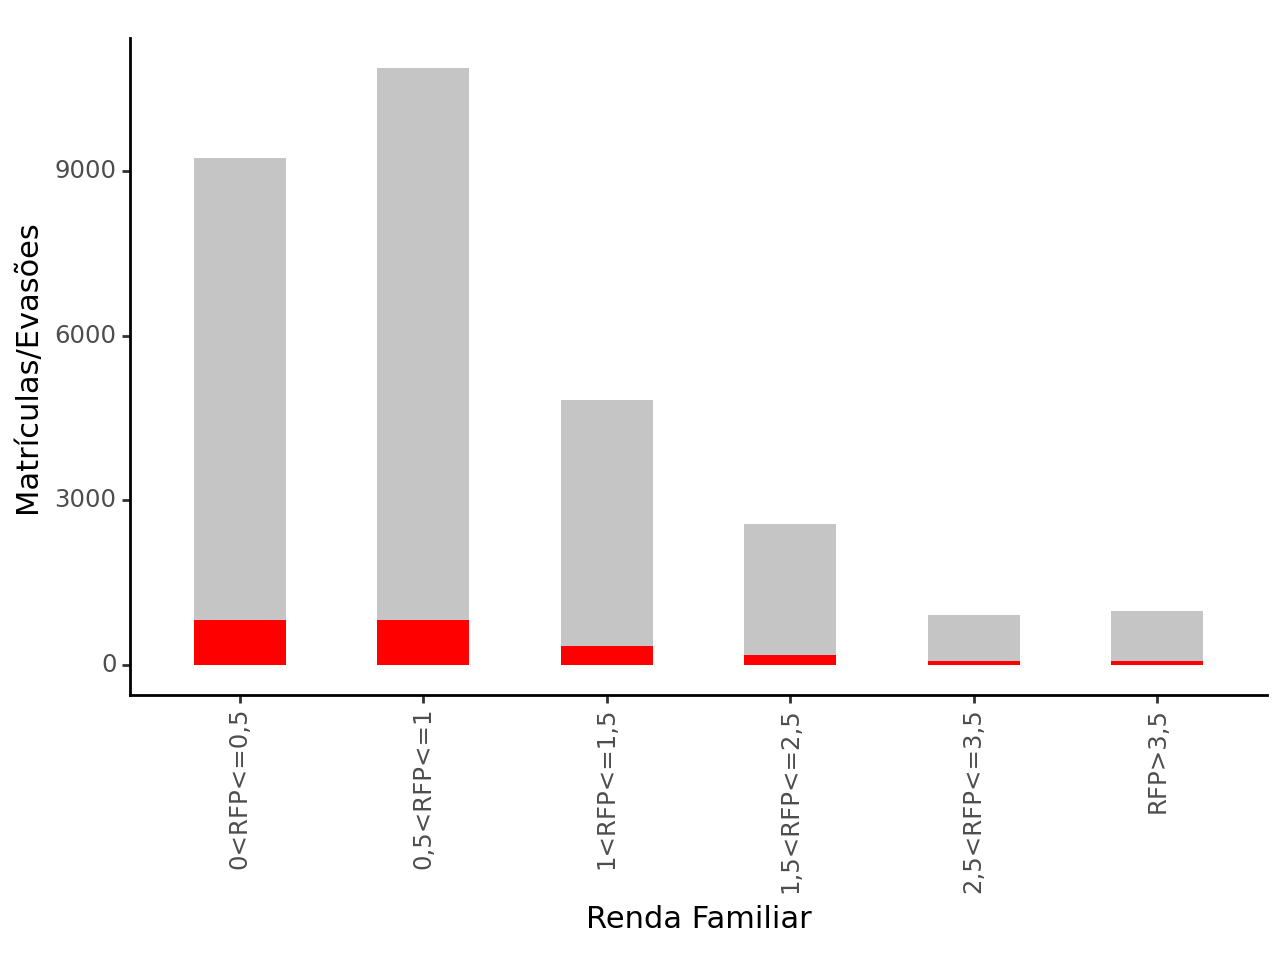

<Figure Size: (640 x 480)>

In [34]:
#Renda Familiar

(
    ggplot(df_evaded, aes(x="Renda Familiar"))
    + geom_histogram(data=df_filtered, mapping=aes(x="Renda Familiar"), binwidth=0.5, alpha=0.35, show_legend=True)
    + geom_histogram(binwidth=0.5, show_legend=True, fill="red")
    + labs(y="Matrículas/Evasões")
    + theme_classic()
    + theme(axis_text_x = element_text(angle=90))
)

**Matrículas/Evasão por: Faixa Etária**

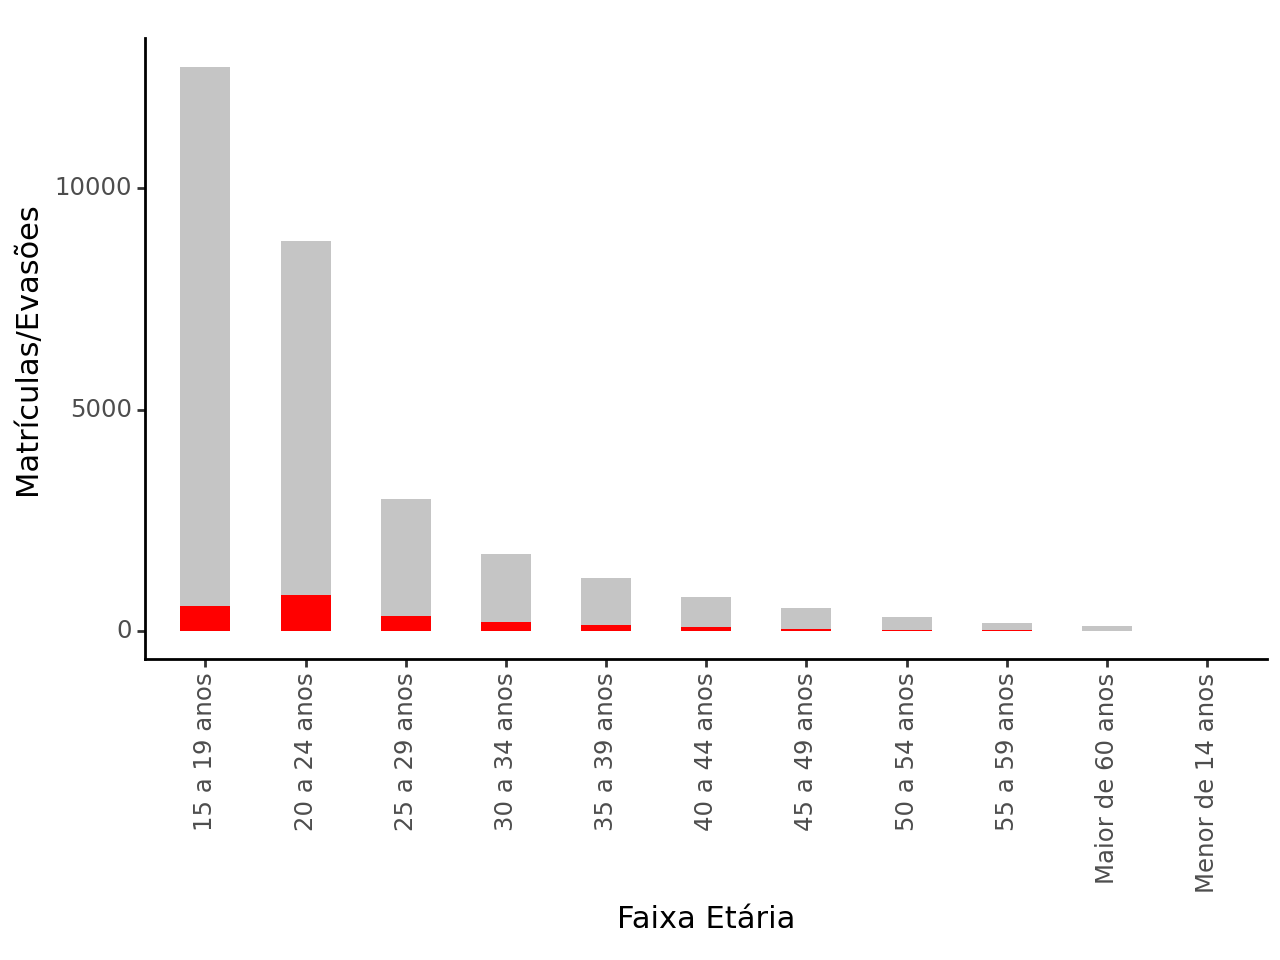

<Figure Size: (640 x 480)>

In [35]:
#Faixa Etária

(
    ggplot(df_evaded, aes(x="Faixa Etária"))
    + geom_histogram(data=df_filtered, mapping=aes(x="Faixa Etária"), binwidth=0.5, alpha=0.35, show_legend=True)
    + geom_histogram(binwidth=0.5, show_legend=True, fill="red")
    + labs(y="Matrículas/Evasões")
    + theme_classic()
    + theme(axis_text_x = element_text(angle=90))
)

**Matrículas/Evasão por: Cor/Raça**

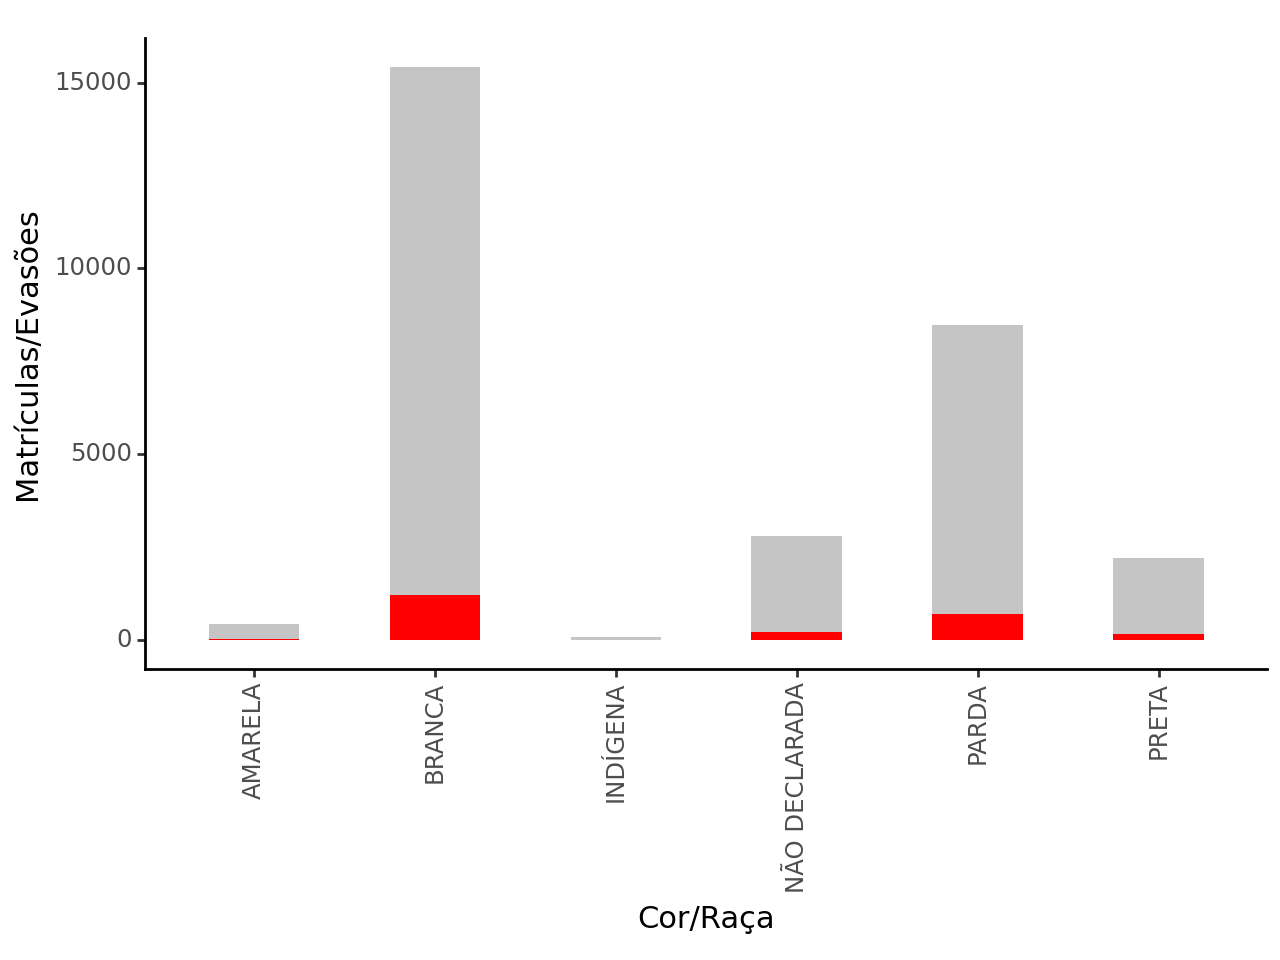

<Figure Size: (640 x 480)>

In [36]:
#Cor/Raça

(
    ggplot(df_evaded, aes(x="Cor/Raça"))
    + geom_histogram(data=df_filtered, mapping=aes(x="Cor/Raça"), binwidth=0.5, alpha=0.35, show_legend=True)
    + geom_histogram(binwidth=0.5, show_legend=True, fill="red")
    + labs(y="Matrículas/Evasões")
    + theme_classic()
    + theme(axis_text_x = element_text(angle=90))
)

**Matrículas/Evasão por: Sexo**

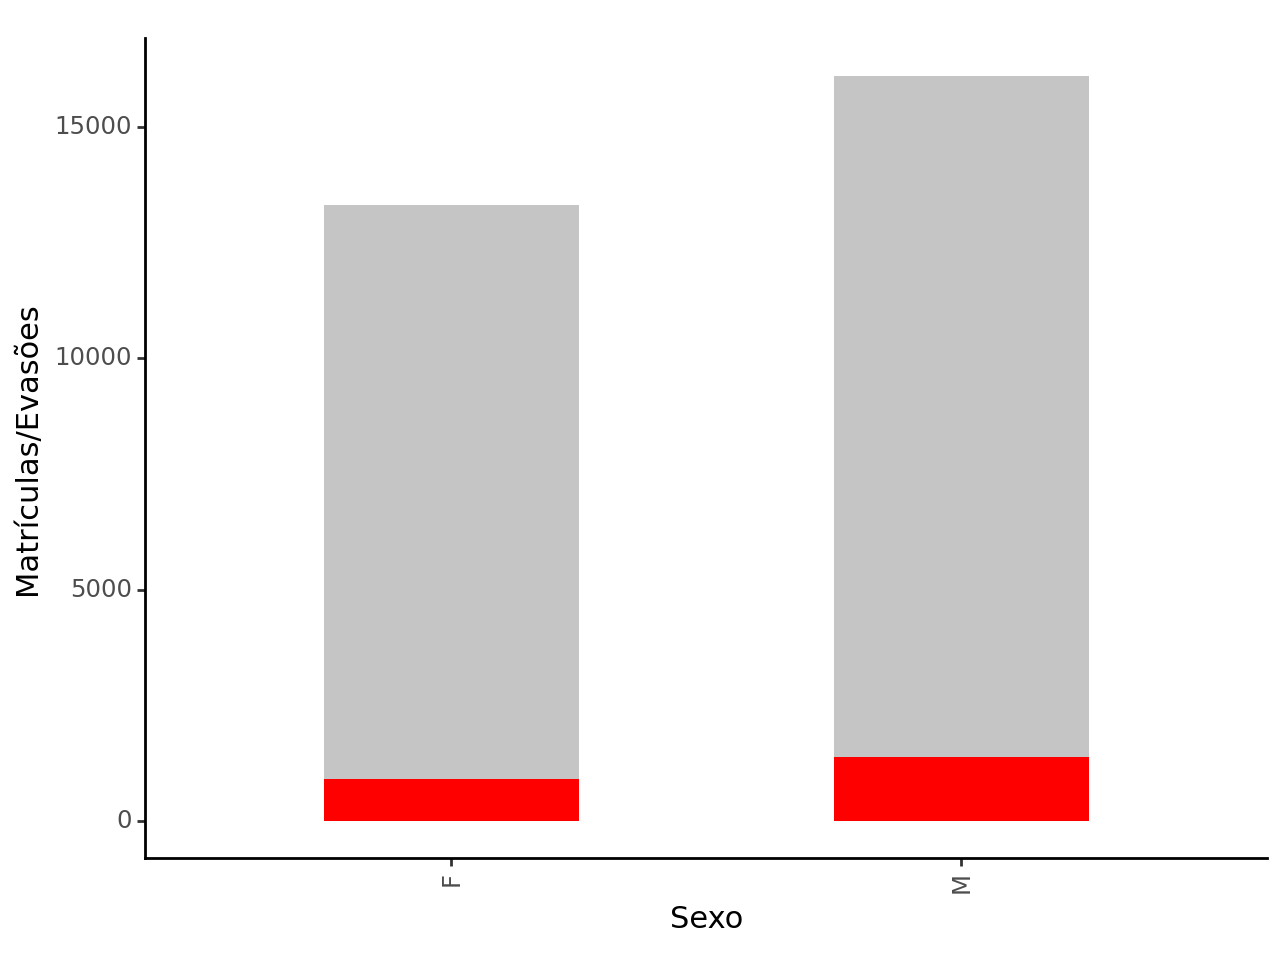

<Figure Size: (640 x 480)>

In [37]:
#Sexo

(
    ggplot(df_evaded, aes(x="Sexo"))
    + geom_histogram(data=df_filtered, mapping=aes(x="Sexo"), binwidth=0.5, alpha=0.35, show_legend=True)
    + geom_histogram(binwidth=0.5, show_legend=True, fill="red")
    + labs(y="Matrículas/Evasões")
    + theme_classic()
    + theme(axis_text_x = element_text(angle=90))
)

# **Teste de Hipóteses**

A análise do teste de Hipótese será feito considerando apenas o conjunto de dados do dataset já filtrado de casos de Evasão **"df_evaded"**, dado que a nossa Hipótese nula singe-se em afirmar que a Renda familiar influencia no nível de evasão.

In [38]:
# 1. Converter os intervalos de RFP dado em intervalo de valores como valores númericos Reais, Atribuindo para cada caso a média
# respectiva do seu intervalo e Acrescentar uma partição desse dataset "df_evaded" em duas categorias principais, sobre as quais se incidirão a análise
# Renda Familiar Abaixo da Média: '0<RFP<=0,5' +  '0,5<RFP<=1' + '1<RFP<=1,5'
# Renda Familiar Acima da Média:  '1,5<RFP<=2,5' +  '2,5<RFP<=3,5' +  'RFP>3,5'
# considerando a média um valor de 1.6

# 1.a) Mapeamento dos intervalos para médias
intervalos = {
    '0<RFP<=0,5': 0.25,
    '0,5<RFP<=1': 0.75,
    '1<RFP<=1,5': 1.25,
    '1,5<RFP<=2,5': 2.0,
    '2,5<RFP<=3,5': 3.0,
    'RFP>3,5': 4.0,
    'Não declarada': None  # Se não declarada, pode ser tratada como NaN ou removida
}

# 1.b) Substituir os intervalos pelas médias calculadas
df_evaded['Renda_Familiar_Media'] = df_evaded['Renda Familiar'].map(intervalos)

# 1.c) Remover linhas com NaN na coluna de renda familiar média (caso aplicável)
df_evaded.dropna(subset=['Renda_Familiar_Media'], inplace=True)

# 1.d) Acrescentar uma coluna de categoria da renda familiar, dividindo os dados em Estudantes de Renda Familiar Abaixo da Média e Acima da Média, considerando 1.6 como a média da Renda Familiar
df_evaded['Categoria_Renda_Familiar_Media'] = df_evaded['Renda_Familiar_Media'].apply(lambda x: 'abaixo_1_6' if x <= 1.6 else 'acima_1_6')
#df_evaded

<ipython-input-38-182cf1b0ca95>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-38-182cf1b0ca95>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-38-182cf1b0ca95>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [39]:
# 1. Separação do dataset de evaded em categorias
df_evaded_rfp_abaixo_1_6 = df_evaded[df_evaded['Categoria_Renda_Familiar_Media'] == 'abaixo_1_6']
df_evaded_rfp_acima_1_6 = df_evaded[df_evaded['Categoria_Renda_Familiar_Media'] == 'acima_1_6']

# 1.a). Calcular o número de casos em cada categoria
num_evaded_rfp_abaixo_1_6 = len(df_evaded_rfp_abaixo_1_6)
num_evaded_rfp_acima_1_6 = len(df_evaded_rfp_acima_1_6)
total_evaded = len(df_evaded)

In [40]:
# 2. Calcular as proporções de casos observados para cada categoria

proporcao_obs_abaixo_1_6, proporcao_obs_acima_1_6 = round(df_evaded['Categoria_Renda_Familiar_Media'].value_counts(normalize=True), 2)

diff_prop_obs = proporcao_obs_abaixo_1_6 - proporcao_obs_acima_1_6

# Imprimir os resultados
print(f"Proporção de casos 'abaixo_1_6': {proporcao_obs_abaixo_1_6}")
print(f"Proporção de casos 'acima_1_6': {proporcao_obs_acima_1_6}")
print(f"A diferença observada entre as categorias de RFP é de: {diff_prop_obs}")

Proporção de casos 'abaixo_1_6': 0.86
Proporção de casos 'acima_1_6': 0.14
A diferença observada entre as categorias de RFP é de: 0.72


In [41]:
# 3. Função de amostragens aleatórias
def sample_replicate(data1, data2, size):

  diffs_categorias_permuted_samples = np.empty(size)

  data = pd.concat([data1, data2])

  for i in range(size):

    # Permutação dos dados
    permuted_data = data.sample(frac=1, replace=True).reset_index(drop=True)

    # Contar proporções
    proporcoes = permuted_data['Categoria_Renda_Familiar_Media'].value_counts(normalize=True)

    # Inicializar proporções
    proporcao_perm_sample_abaixo_1_6 = proporcoes.get('abaixo_1_6', 0)
    proporcao_perm_sample_acima_1_6 = proporcoes.get('acima_1_6', 0)

    diff_prop_perm_sample = proporcao_perm_sample_abaixo_1_6 - proporcao_perm_sample_acima_1_6
    diffs_categorias_permuted_samples[i] = round(diff_prop_perm_sample, 2)

  return diffs_categorias_permuted_samples

# 4. Aplicação da técnica de bootstrap
np.random.seed(42)  # Definir uma semente para reprodutibilidade
diffs_categorias_permuted_samples = sample_replicate(df_evaded_rfp_abaixo_1_6, df_evaded_rfp_acima_1_6, size=10000)

In [42]:
diffs_categorias_permuted_samples[:10]

array([0.71, 0.72, 0.72, 0.76, 0.73, 0.72, 0.72, 0.71, 0.7 , 0.71])

In [43]:
p = np.sum( diffs_categorias_permuted_samples >= diff_prop_obs) / len(diffs_categorias_permuted_samples)

p

0.5009

p-valor: 0.5009
Intervalo de confiança (95%): [0.69 0.74]
Diferença observada: 0.72


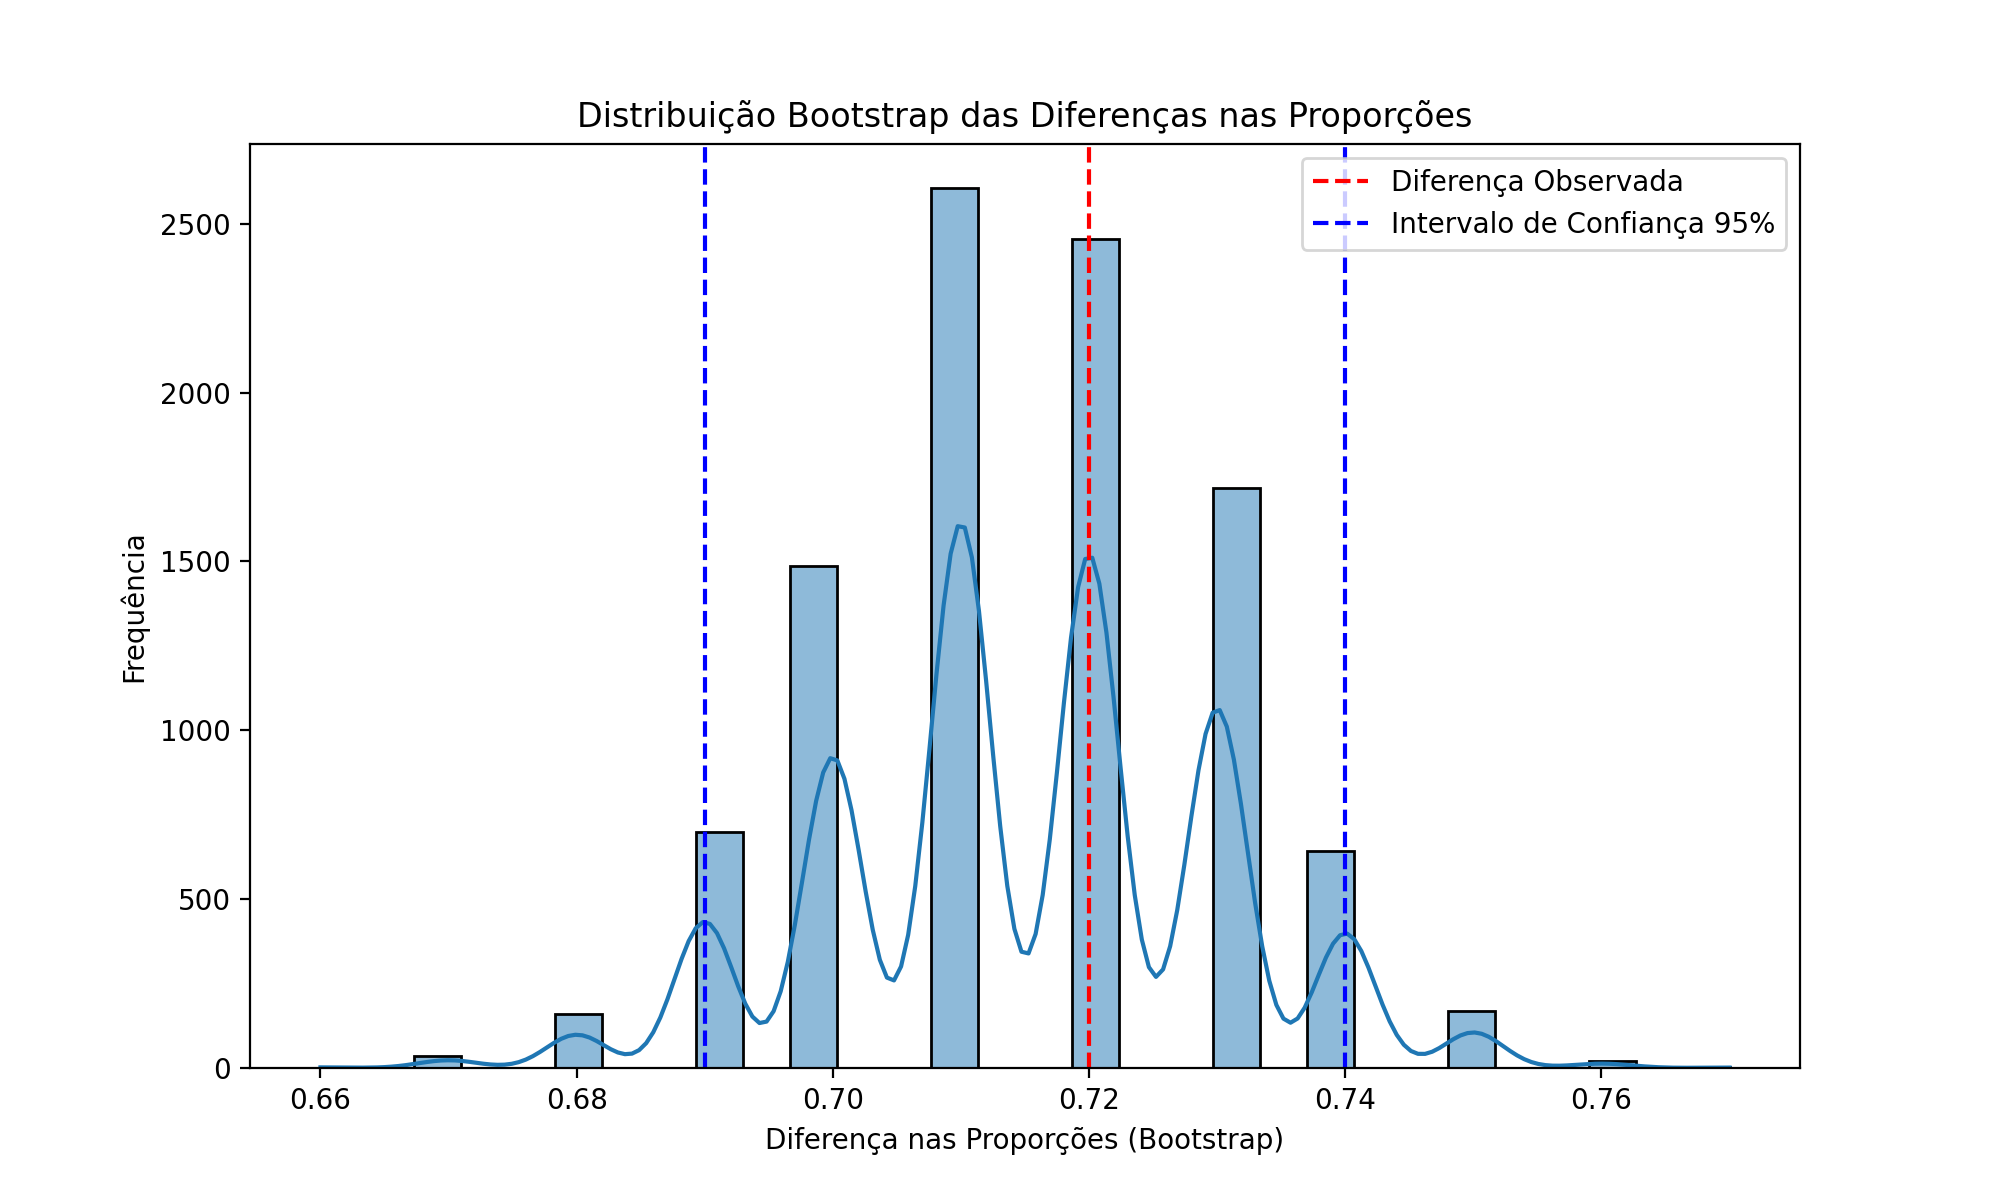

In [44]:
# 4. Calcular o p-valor
p_val = np.mean(np.abs(diffs_categorias_permuted_samples) >= np.abs(diff_prop_obs))

# 5. Calcular o intervalo de confiança
conf_int = np.percentile(diffs_categorias_permuted_samples, [2.5, 97.5])

# Resultados
print(f"p-valor: {p_val}")
print(f"Intervalo de confiança (95%): {conf_int}")
print(f"Diferença observada: {diff_prop_obs}")

# 6. Plotar a distribuição bootstrap
plt.figure(figsize=(10, 6))
sns.histplot(diffs_categorias_permuted_samples, bins=30, kde=True)
plt.axvline(x=diff_prop_obs, color='red', linestyle='--', label='Diferença Observada')
plt.axvline(x=conf_int[0], color='blue', linestyle='--', label='Intervalo de Confiança 95%')
plt.axvline(x=conf_int[1], color='blue', linestyle='--')
plt.xlabel('Diferença nas Proporções (Bootstrap)')
plt.ylabel('Frequência')
plt.title('Distribuição Bootstrap das Diferenças nas Proporções')
plt.legend()
plt.show()



---

# **Teste de Hipóteses - Qui-Quadrada**

In [45]:
# Adicionar a coluna de evasão binária
df_filtered['Evasao'] = df_filtered['Situação de Matrícula'].apply(lambda x: "Evadido" if x in ['Abandono', 'Cancelada', 'Desligada'] else "Não Evadido")

<ipython-input-45-531720e99ade>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [46]:
chi = pd.crosstab(df_filtered["Renda Familiar"], df_filtered["Evasao"])
chi

Evasao,Evadido,Não Evadido
Renda Familiar,,
"0<RFP<=0,5",809,8432
"0,5<RFP<=1",812,10068
"1<RFP<=1,5",352,4485
"1,5<RFP<=2,5",173,2389
"2,5<RFP<=3,5",78,833
"RFP>3,5",77,898


In [47]:
# Cálculo do Qui-Quadrado a partir da tabela de contingência
chi_scores = chi2_contingency(chi)
chi_scores

Chi2ContingencyResult(statistic=19.833609589805565, pvalue=0.0013428318862340307, dof=5, expected_freq=array([[  723.10212202,  8517.89787798],
       [  851.35278515, 10028.64721485],
       [  378.49204244,  4458.50795756],
       [  200.47480106,  2361.52519894],
       [   71.28514589,   839.71485411],
       [   76.29310345,   898.70689655]]))

In [48]:
def qui_quadrado(df, variavel, lista):

  # Calcular Qui2 e p-valor para cada variável e colocar resultado num df
  d = {'Qui2': [], 'p-Valor': []}

  for l in lista:

      # Cria tabela que relaciona variável com lista
      tab = pd.crosstab(df[variavel], df[l])

      # Calcula o qui2 entre as duas variáveis
      chi_scores = chi2_contingency(tab)

      # Recupera o valor e p-value do teste
      scores = pd.Series(chi_scores[0])
      pvalues = pd.Series(chi_scores[1])

      # Adiciona resultado ao dicionário
      d['Qui2'].append(scores[0])
      d['p-Valor'].append(pvalues[0])

  # Transformar dicionário em dataframe
  chi_squared = pd.DataFrame(d)

  # Formato de visualização dos números
  pd.options.display.float_format = "{:,.2f}".format

  # Renomear linhas do df
  for n, l in zip(np.arange(0, len(lista), 1), lista[0:len(lista)]):
    chi_squared = chi_squared.rename(index = {n: l})

  # Mostrar em ordem crescente para o p-valor
  chi_squared = chi_squared.sort_values(by = 'p-Valor', ascending = True)

  # Visualizar df
  return chi_squared

In [49]:
vars = ['Renda Familiar', 'Cor/Raça', 'Faixa Etária', 'Sexo', 'Tipo de Curso']

qui_quadrado(df_filtered, "Evasao", vars)

,Qui2,p-Valor
Faixa Etária,381.25,0.00
Tipo de Curso,52.07,0.00
Sexo,28.61,0.00
Renda Familiar,19.83,0.00
Cor/Raça,7.77,0.17


Partindo de um bechmark de 0.05 para o p-valor, as variáveis **Faixa Etária**, **Tipo de Curso**, **Sexo** e **Renda Familiar**, estão relacionados com a Evasão dos estudantes.

In [50]:
def analise_bi(df, var1, var2, ordem_linhas, ordem_colunas):

    df_group = df.groupby([var1, var2])[var2].count().unstack(var2).fillna(0)

    df_group = df_group.reindex(ordem_linhas)

    # Reordenar colunas
    df_group = df_group[ordem_colunas]

    return df_group

In [51]:
def barras_empilhadas_porcentagem(df_group, titulo, barWidth = 0.75):

    if len(df_group.columns) == 2:

        total = [ i+j for i, j in zip(df_group.iloc[:,0], df_group.iloc[:,1])]
        bar1 = [ i / j * 100 for i, j in zip(df_group.iloc[:,0], total)]
        bar2 = [ i / j * 100 for i, j in zip(df_group.iloc[:,1], total)]

        r = df_group.index

        # Barra 1
        plt.bar(r, bar1, color = '#F54337', edgecolor = 'white', width = barWidth, label = df_group.columns[0])
        # Barra 2
        plt.bar(r, bar2, bottom = bar1, color = '#446BC4', edgecolor = 'white', width = barWidth, label = df_group.columns[1])


    elif len(df_group.columns) == 3:

        total = [ i+j+k for i, j, k in zip(df_group.iloc[:,0], df_group.iloc[:,1], df_group.iloc[:,2])]
        bar1 = [ i / j * 100 for i, j in zip(df_group.iloc[:,0], total)]
        bar2 = [ i / j * 100 for i, j in zip(df_group.iloc[:,1], total)]
        bar3 = [ i / j * 100 for i, j in zip(df_group.iloc[:,2], total)]

        r = df_group.index

        # Barra 1
        plt.bar(r, bar1, color = '#FFCC00', edgecolor = 'white', width = barWidth, label = df_group.columns[0])
        # Barra 2
        plt.bar(r, bar2, bottom = bar1, color = '#F39000', edgecolor = 'white', width = barWidth, label = df_group.columns[1])
        # Barra 3
        plt.bar(r, bar3, bottom = [i+j for i, j in zip(bar1, bar2)], color = '#F54337', edgecolor = 'white', width = barWidth, label = df_group.columns[2])

    elif len(df_group.columns) == 4:

        total = [ i+j+k+l for i, j, k, l in zip(df_group.iloc[:,0], df_group.iloc[:,1], df_group.iloc[:,2], df_group.iloc[:,3])]
        bar1 = [ i / j * 100 for i, j in zip(df_group.iloc[:,0], total)]
        bar2 = [ i / j * 100 for i, j in zip(df_group.iloc[:,1], total)]
        bar3 = [ i / j * 100 for i, j in zip(df_group.iloc[:,2], total)]
        bar4 = [ i / j * 100 for i, j in zip(df_group.iloc[:,3], total)]

        r = df_group.index

        # Barra 1
        plt.bar(r, bar1, color = '#FFCC00', edgecolor = 'white', width = barWidth, label = df_group.columns[0])
        # Barra 2
        plt.bar(r, bar2, bottom = bar1, color = '#F39000', edgecolor = 'white', width = barWidth, label = df_group.columns[1])
        # Barra 3
        plt.bar(r, bar3, bottom = [i+j for i, j in zip(bar1, bar2)], color = '#F54337', edgecolor = 'white', width = barWidth, label = df_group.columns[2])
        # Barra 4
        plt.bar(r, bar4, bottom = [i+j+k for i, j, k in zip(bar1, bar2, bar3)], color = '#8C0046', edgecolor = 'white', width = barWidth, label = df_group.columns[3])

    elif len(df_group.columns) == 5:

        total = [ i+j+k+l+m for i, j, k, l, m in zip(df_group.iloc[:,0], df_group.iloc[:,1], df_group.iloc[:,2], df_group.iloc[:,3], df_group.iloc[:,4])]
        bar1 = [ i / j * 100 for i, j in zip(df_group.iloc[:,0], total)]
        bar2 = [ i / j * 100 for i, j in zip(df_group.iloc[:,1], total)]
        bar3 = [ i / j * 100 for i, j in zip(df_group.iloc[:,2], total)]
        bar4 = [ i / j * 100 for i, j in zip(df_group.iloc[:,3], total)]
        bar5 = [ i / j * 100 for i, j in zip(df_group.iloc[:,4], total)]

        r = df_group.index

        # Barra 1
        plt.bar(r, bar1, color = '#FFCC00', edgecolor = 'white', width = barWidth, label = df_group.columns[0])
        # Barra 2
        plt.bar(r, bar2, bottom = bar1, color = '#F39000', edgecolor = 'white', width = barWidth, label = df_group.columns[1])
        # Barra 3
        plt.bar(r, bar3, bottom = [i+j for i, j in zip(bar1, bar2)], color = '#F54337', edgecolor = 'white', width = barWidth, label = df_group.columns[2])
        # Barra 4
        plt.bar(r, bar4, bottom = [i+j+k for i, j, k in zip(bar1, bar2, bar3)], color = '#8C0046', edgecolor = 'white', width = barWidth, label = df_group.columns[3])
        # Barra 5
        plt.bar(r, bar5, bottom = [i+j+k+l for i, j, k, l in zip(bar1, bar2, bar3, bar4)], color = '#446BC4', edgecolor = 'white', width = barWidth, label = df_group.columns[4])

    elif len(df_group.columns) == 6:

        total = [ i+j+k+l+m+n for i, j, k, l, m, n in zip(df_group.iloc[:,0], df_group.iloc[:,1], df_group.iloc[:,2], df_group.iloc[:,3], df_group.iloc[:,4], df_group.iloc[:,5])]
        bar1 = [ i / j * 100 for i, j in zip(df_group.iloc[:,0], total)]
        bar2 = [ i / j * 100 for i, j in zip(df_group.iloc[:,1], total)]
        bar3 = [ i / j * 100 for i, j in zip(df_group.iloc[:,2], total)]
        bar4 = [ i / j * 100 for i, j in zip(df_group.iloc[:,3], total)]
        bar5 = [ i / j * 100 for i, j in zip(df_group.iloc[:,4], total)]
        bar6 = [ i / j * 100 for i, j in zip(df_group.iloc[:,5], total)]

        r = df_group.index

        # Barra 1
        plt.bar(r, bar1, color = '#FFCC00', edgecolor = 'white', width = barWidth, label = df_group.columns[0])
        # Barra 2
        plt.bar(r, bar2, bottom = bar1, color = '#F39000', edgecolor = 'white', width = barWidth, label = df_group.columns[1])
        # Barra 3
        plt.bar(r, bar3, bottom = [i+j for i, j in zip(bar1, bar2)], color = '#F54337', edgecolor = 'white', width = barWidth, label = df_group.columns[2])
        # Barra 4
        plt.bar(r, bar4, bottom = [i+j+k for i, j, k in zip(bar1, bar2, bar3)], color = '#8C0046', edgecolor = 'white', width = barWidth, label = df_group.columns[3])
        # Barra 5
        plt.bar(r, bar5, bottom = [i+j+k+l for i, j, k, l in zip(bar1, bar2, bar3, bar4)], color = '#446BC4', edgecolor = 'white', width = barWidth, label = df_group.columns[4])
        # Barra 6
        plt.bar(r, bar6, bottom = [i+j+k+l+m for i, j, k, l, m in zip(bar1, bar2, bar3, bar4, bar5)], color = '#009EBF', edgecolor = 'white', width = barWidth, label = df_group.columns[5])

    elif len(df_group.columns) == 7:

        total = [ i+j+k+l+m+n+o for i, j, k, l, m, n, o in zip(df_group.iloc[:,0], df_group.iloc[:,1], df_group.iloc[:,2], df_group.iloc[:,3], df_group.iloc[:,4], df_group.iloc[:,5], df_group.iloc[:,6])]
        bar1 = [ i / j * 100 for i, j in zip(df_group.iloc[:,0], total)]
        bar2 = [ i / j * 100 for i, j in zip(df_group.iloc[:,1], total)]
        bar3 = [ i / j * 100 for i, j in zip(df_group.iloc[:,2], total)]
        bar4 = [ i / j * 100 for i, j in zip(df_group.iloc[:,3], total)]
        bar5 = [ i / j * 100 for i, j in zip(df_group.iloc[:,4], total)]
        bar6 = [ i / j * 100 for i, j in zip(df_group.iloc[:,5], total)]
        bar7 = [ i / j * 100 for i, j in zip(df_group.iloc[:,6], total)]

        r = df_group.index

        # Barra 1
        plt.bar(r, bar1, color = '#FFCC00', edgecolor = 'white', width = barWidth, label = df_group.columns[0])
        # Barra 2
        plt.bar(r, bar2, bottom = bar1, color = '#F39000', edgecolor = 'white', width = barWidth, label = df_group.columns[1])
        # Barra 3
        plt.bar(r, bar3, bottom = [i+j for i, j in zip(bar1, bar2)], color = '#F54337', edgecolor = 'white', width = barWidth, label = df_group.columns[2])
        # Barra 4
        plt.bar(r, bar4, bottom = [i+j+k for i, j, k in zip(bar1, bar2, bar3)], color = '#8C0046', edgecolor = 'white', width = barWidth, label = df_group.columns[3])
        # Barra 5
        plt.bar(r, bar5, bottom = [i+j+k+l for i, j, k, l in zip(bar1, bar2, bar3, bar4)], color = '#446BC4', edgecolor = 'white', width = barWidth, label = df_group.columns[4])
        # Barra 6
        plt.bar(r, bar6, bottom = [i+j+k+l+m for i, j, k, l, m in zip(bar1, bar2, bar3, bar4, bar5)], color = '#009EBF', edgecolor = 'white', width = barWidth, label = df_group.columns[5])
        # Barra 7
        plt.bar(r, bar7, bottom = [i+j+k+l+m+n for i, j, k, l, m, n in zip(bar1, bar2, bar3, bar4, bar5, bar6)], color = '#2FD07B', edgecolor = 'white', width = barWidth, label = df_group.columns[6])

    else:
        return print('Número de categorias inválido')

    # Linha horizontal
    plt.axhline(linewidth = 2, color = 'black')

    # Adicionar titulo
    plt.title(titulo, fontsize = 16, pad = 20);

    # Adicionar legenda
    plt.legend(loc = 'lower center', bbox_to_anchor = (0.5, -0.17), ncol = 3, frameon = False)

    # Remover eixo y
    plt.yticks([])

    # Remover ticks
    plt.tick_params(left = False)
    plt.tick_params(bottom = False)

    # Alterar tamanho e salvar gráfico
    fig = plt.gcf()
    fig.set_size_inches(13, 8)

    # Mostrar gráfico
    plt.show()

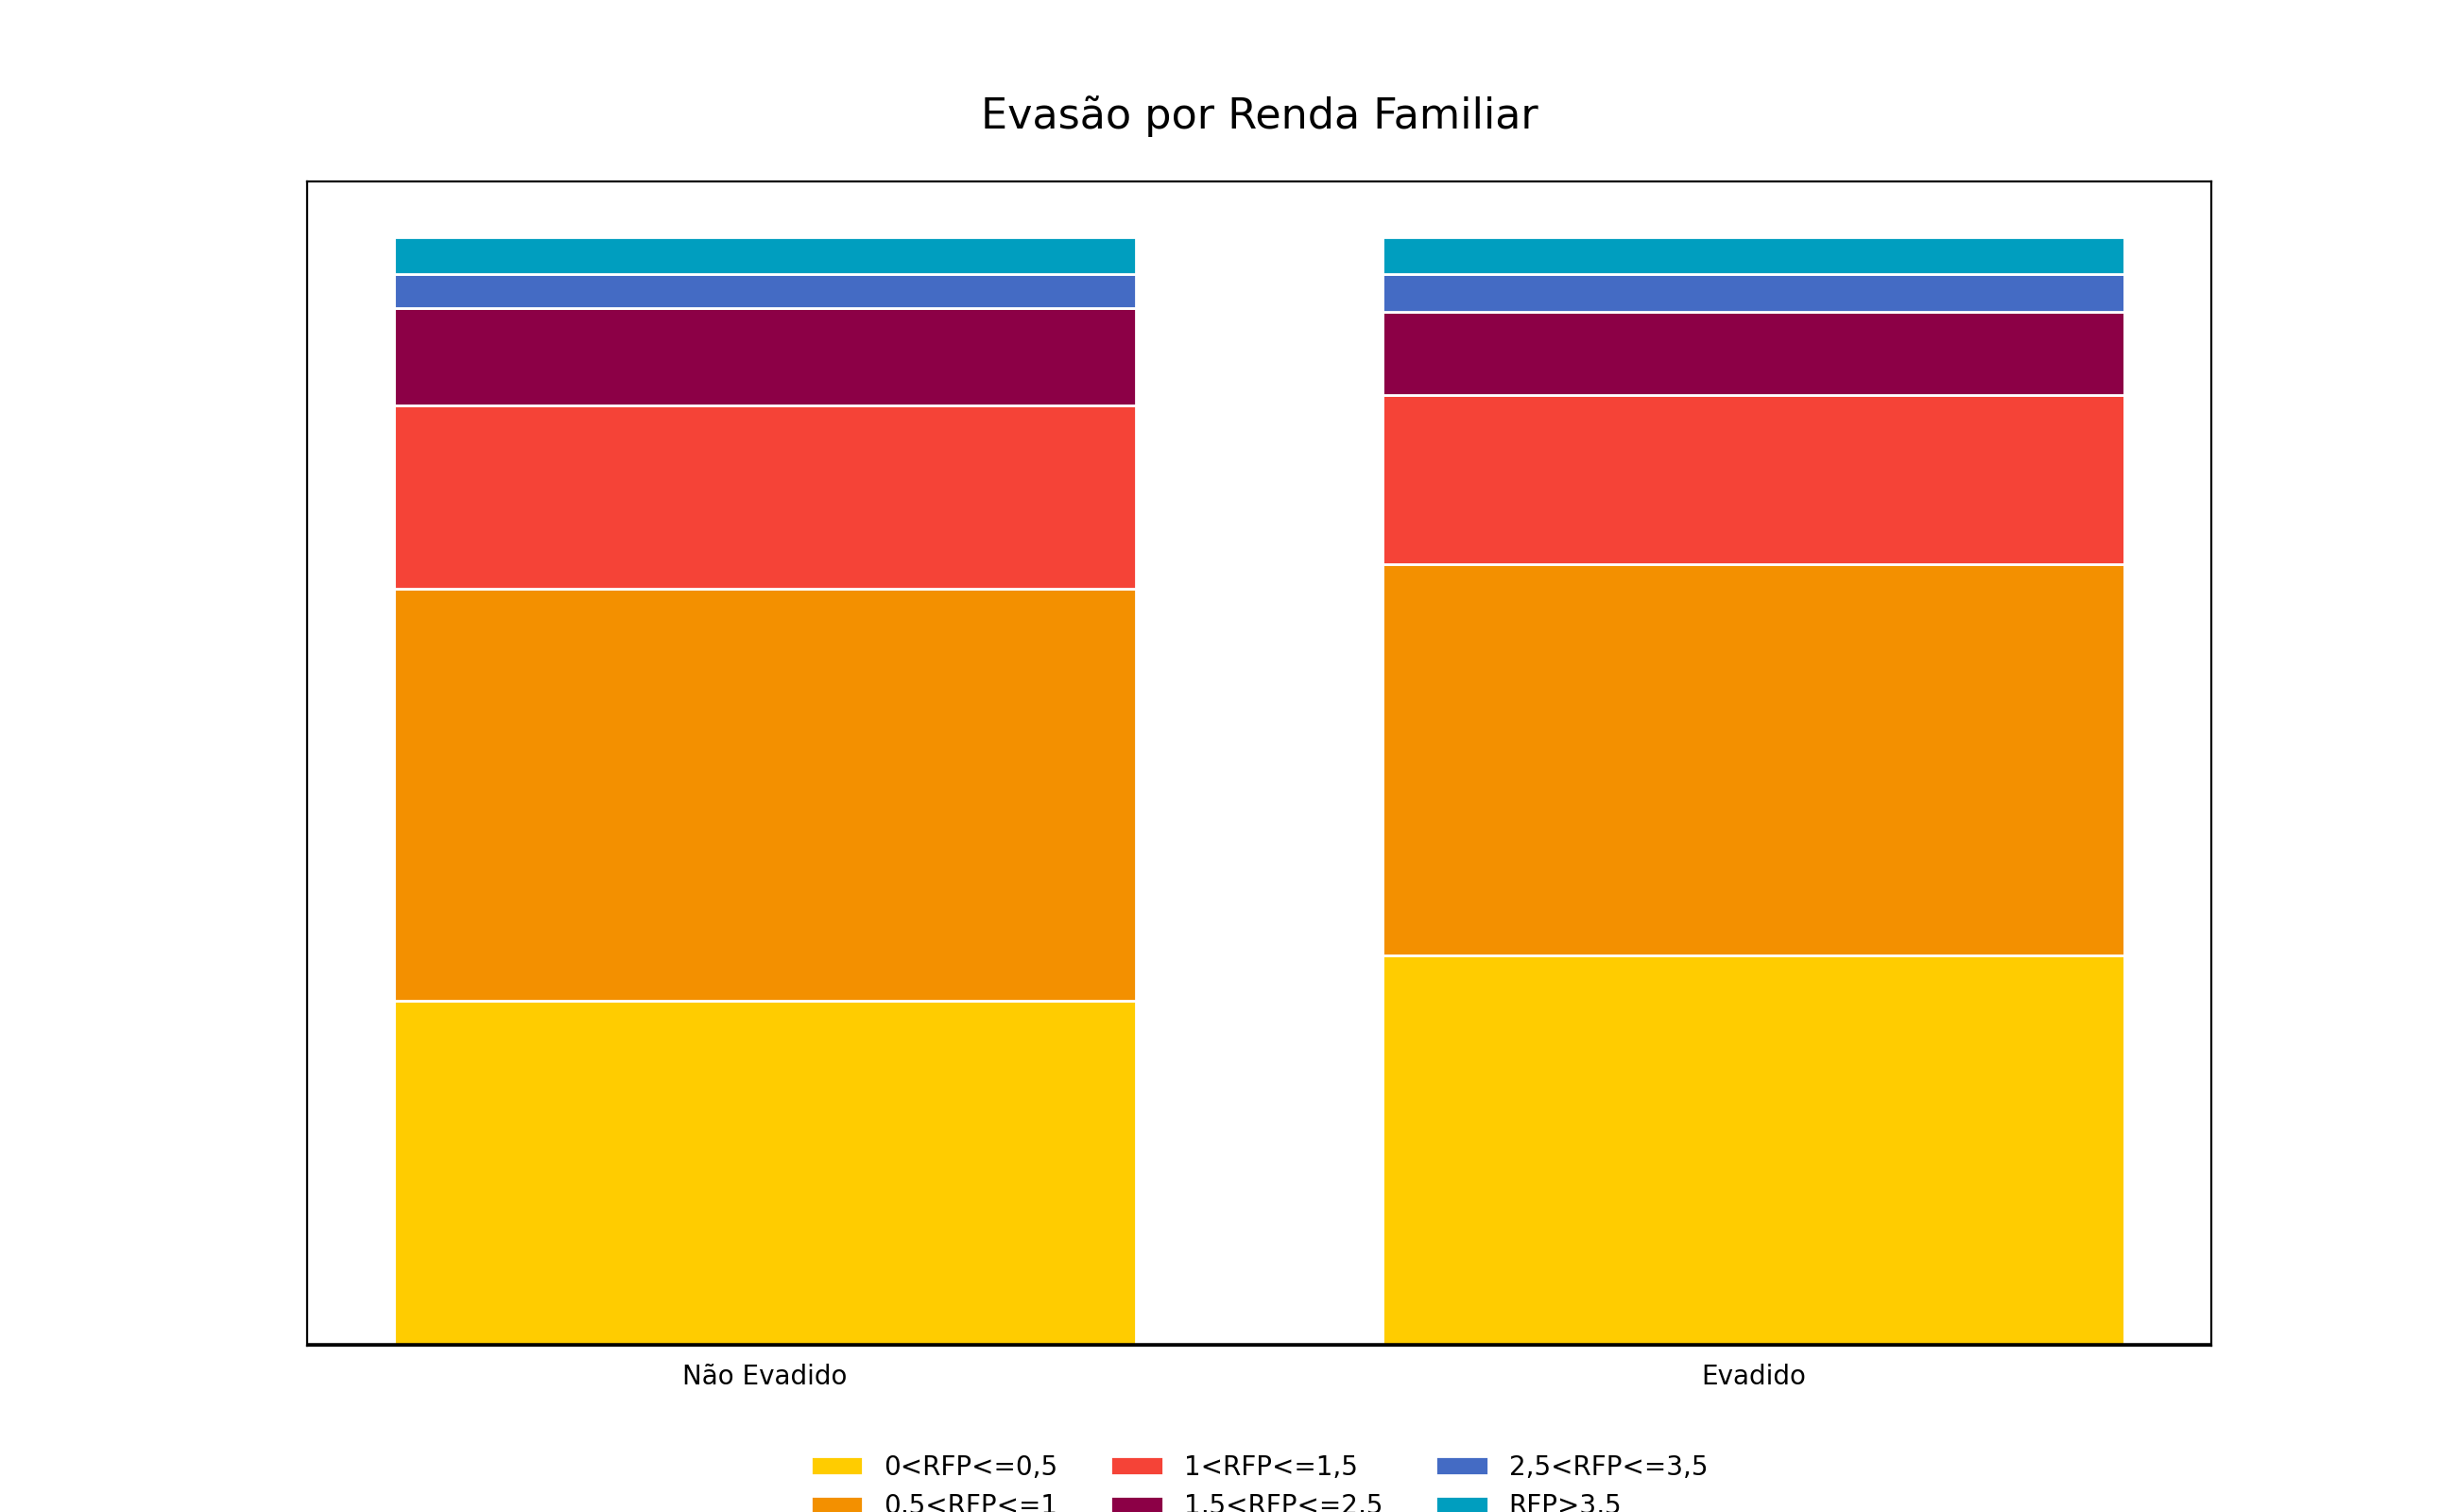

In [52]:
var1 = 'Evasao'
var2 = 'Renda Familiar'

ordem_linhas = ['Não Evadido', 'Evadido']
ordem_colunas = ['0<RFP<=0,5', '0,5<RFP<=1', '1<RFP<=1,5', '1,5<RFP<=2,5', '2,5<RFP<=3,5', 'RFP>3,5']

rank_Evasao = analise_bi(df_filtered, var1, var2, ordem_linhas, ordem_colunas)
titulo = 'Evasão por Renda Familiar'

barras_empilhadas_porcentagem(rank_Evasao, titulo)

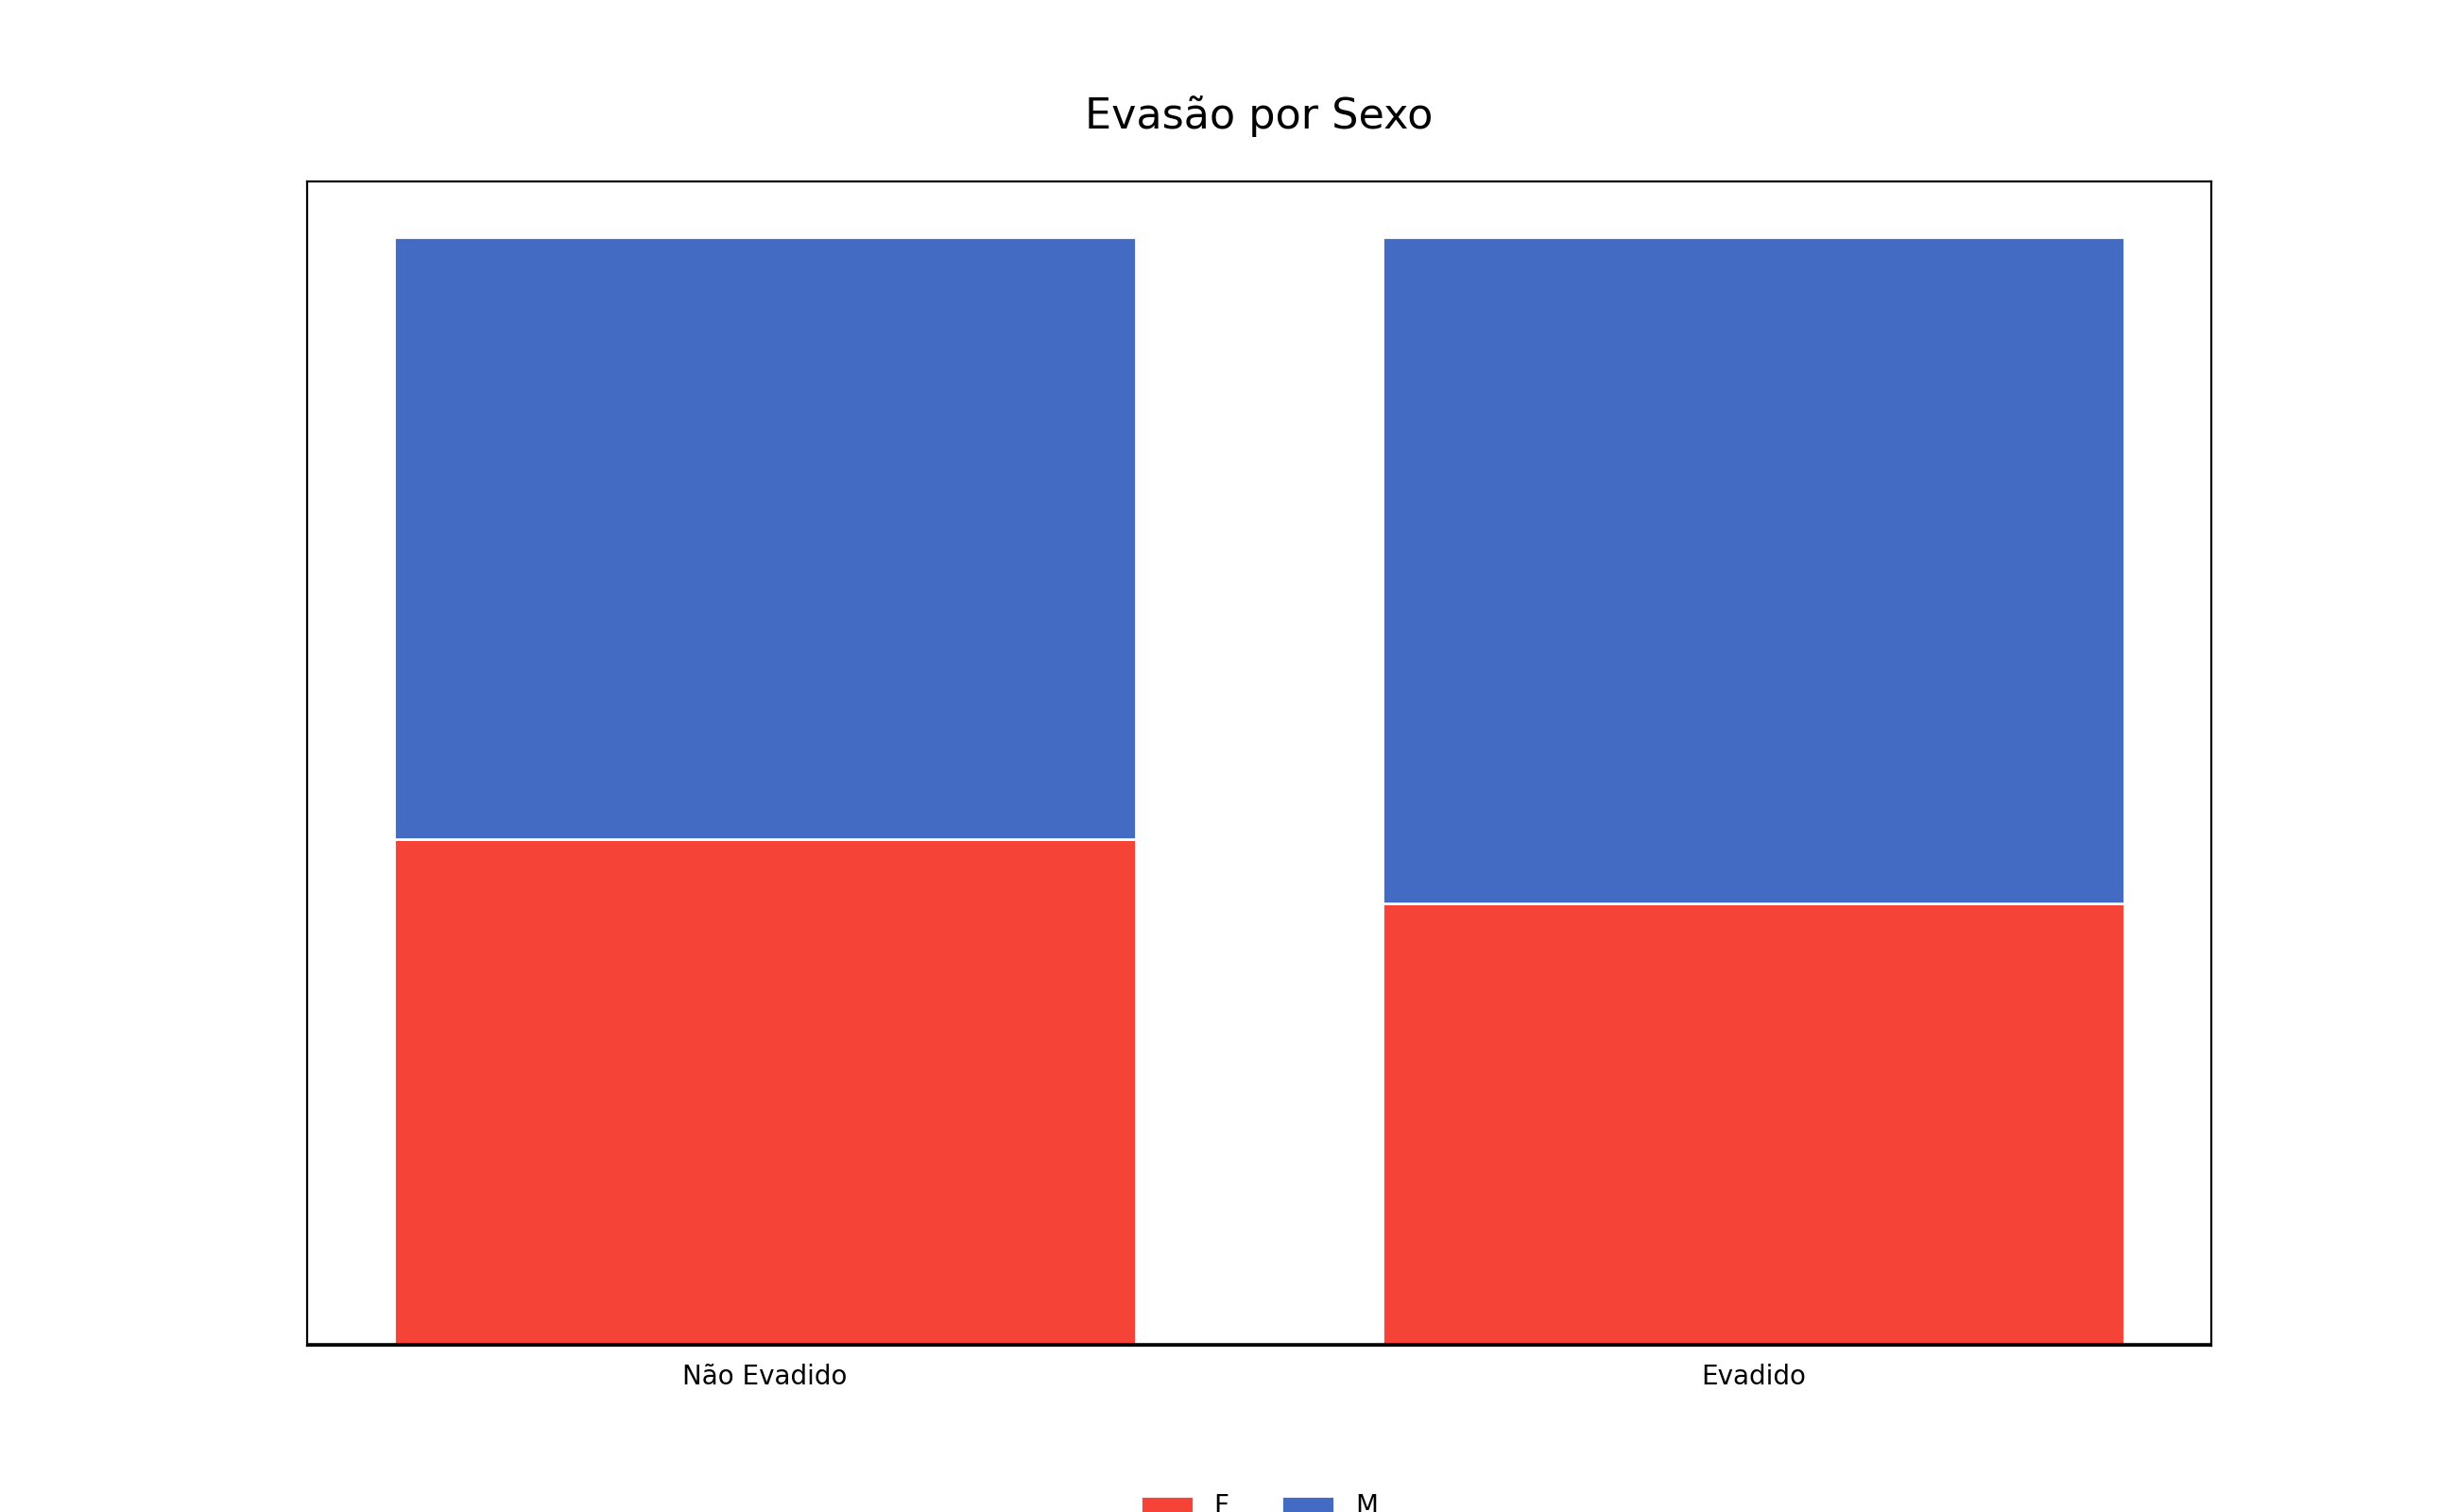

In [53]:
var1 = 'Evasao'
var2 = 'Sexo'

ordem_linhas = ['Não Evadido', 'Evadido']
ordem_colunas = ['F', 'M']

rank_Sexo = analise_bi(df_filtered, var1, var2, ordem_linhas, ordem_colunas)
titulo = 'Evasão por Sexo'

barras_empilhadas_porcentagem(rank_Sexo, titulo)

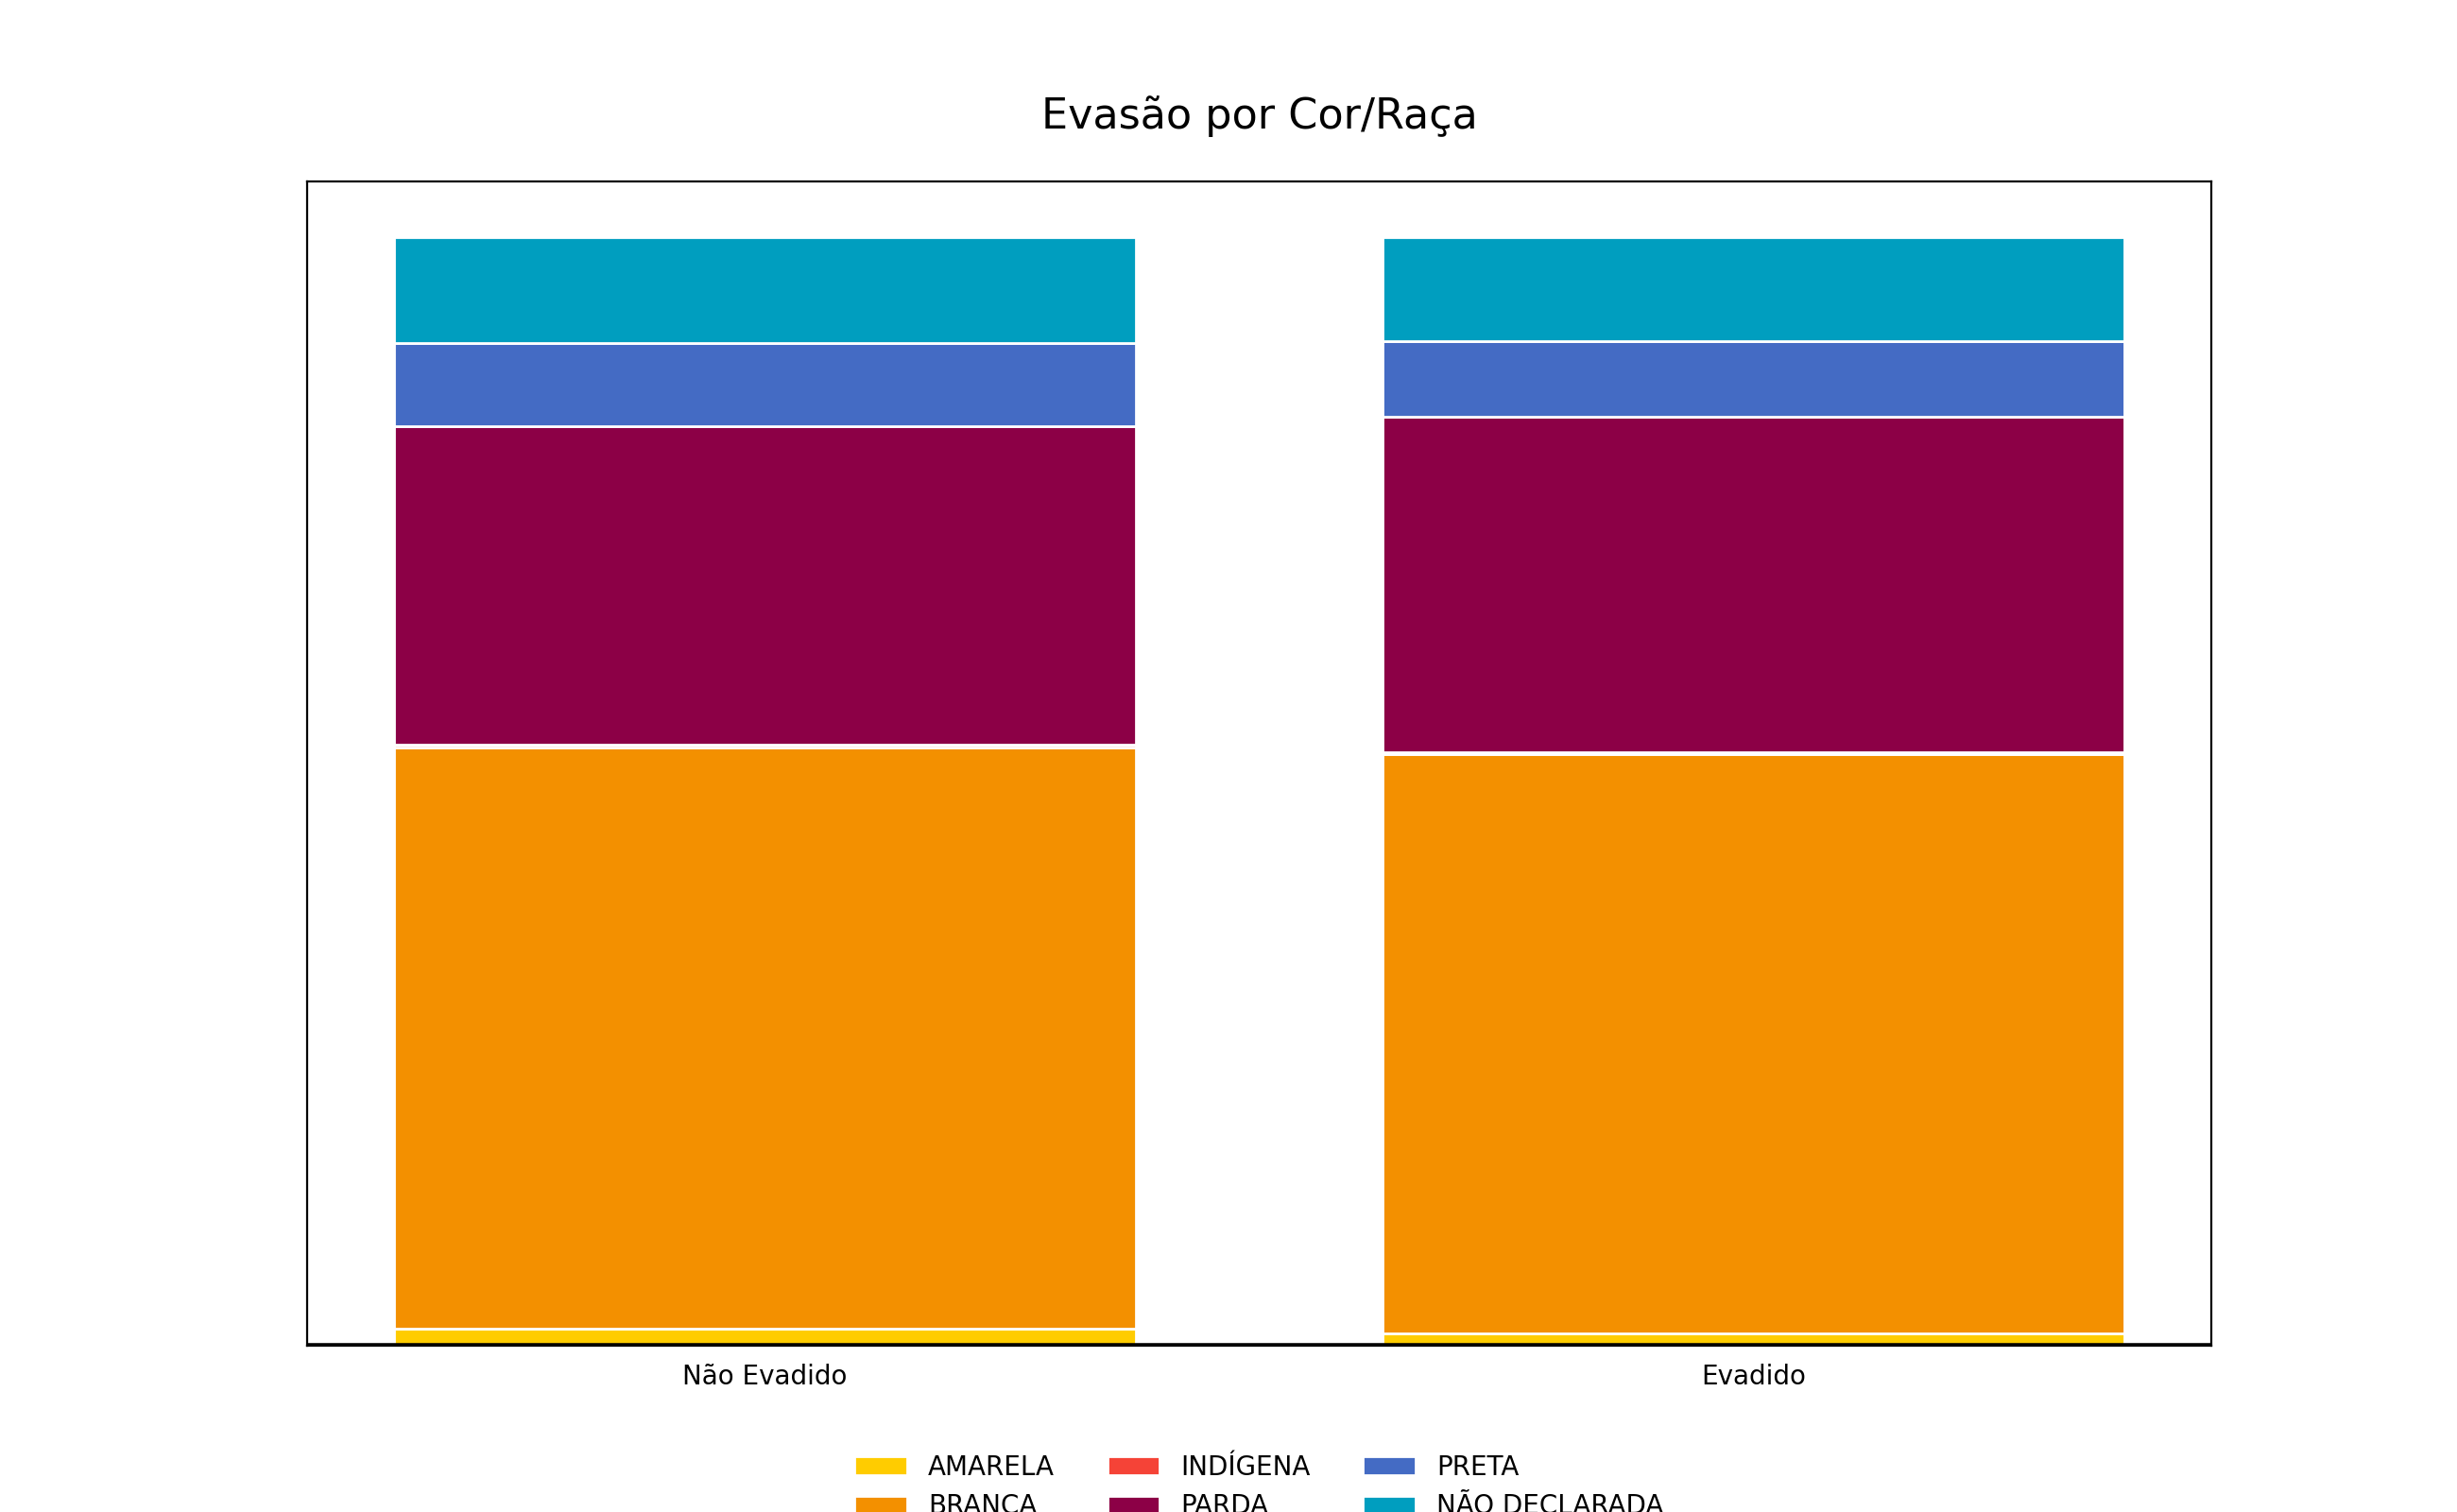

In [54]:
var1 = 'Evasao'
var2 = 'Cor/Raça'

ordem_linhas = ['Não Evadido', 'Evadido']
ordem_colunas = ['AMARELA', 'BRANCA', 'INDÍGENA', 'PARDA', 'PRETA', 'NÃO DECLARADA' ]

rank_Raca = analise_bi(df_filtered, var1, var2, ordem_linhas, ordem_colunas)
titulo = 'Evasão por Cor/Raça'

barras_empilhadas_porcentagem(rank_Raca, titulo)

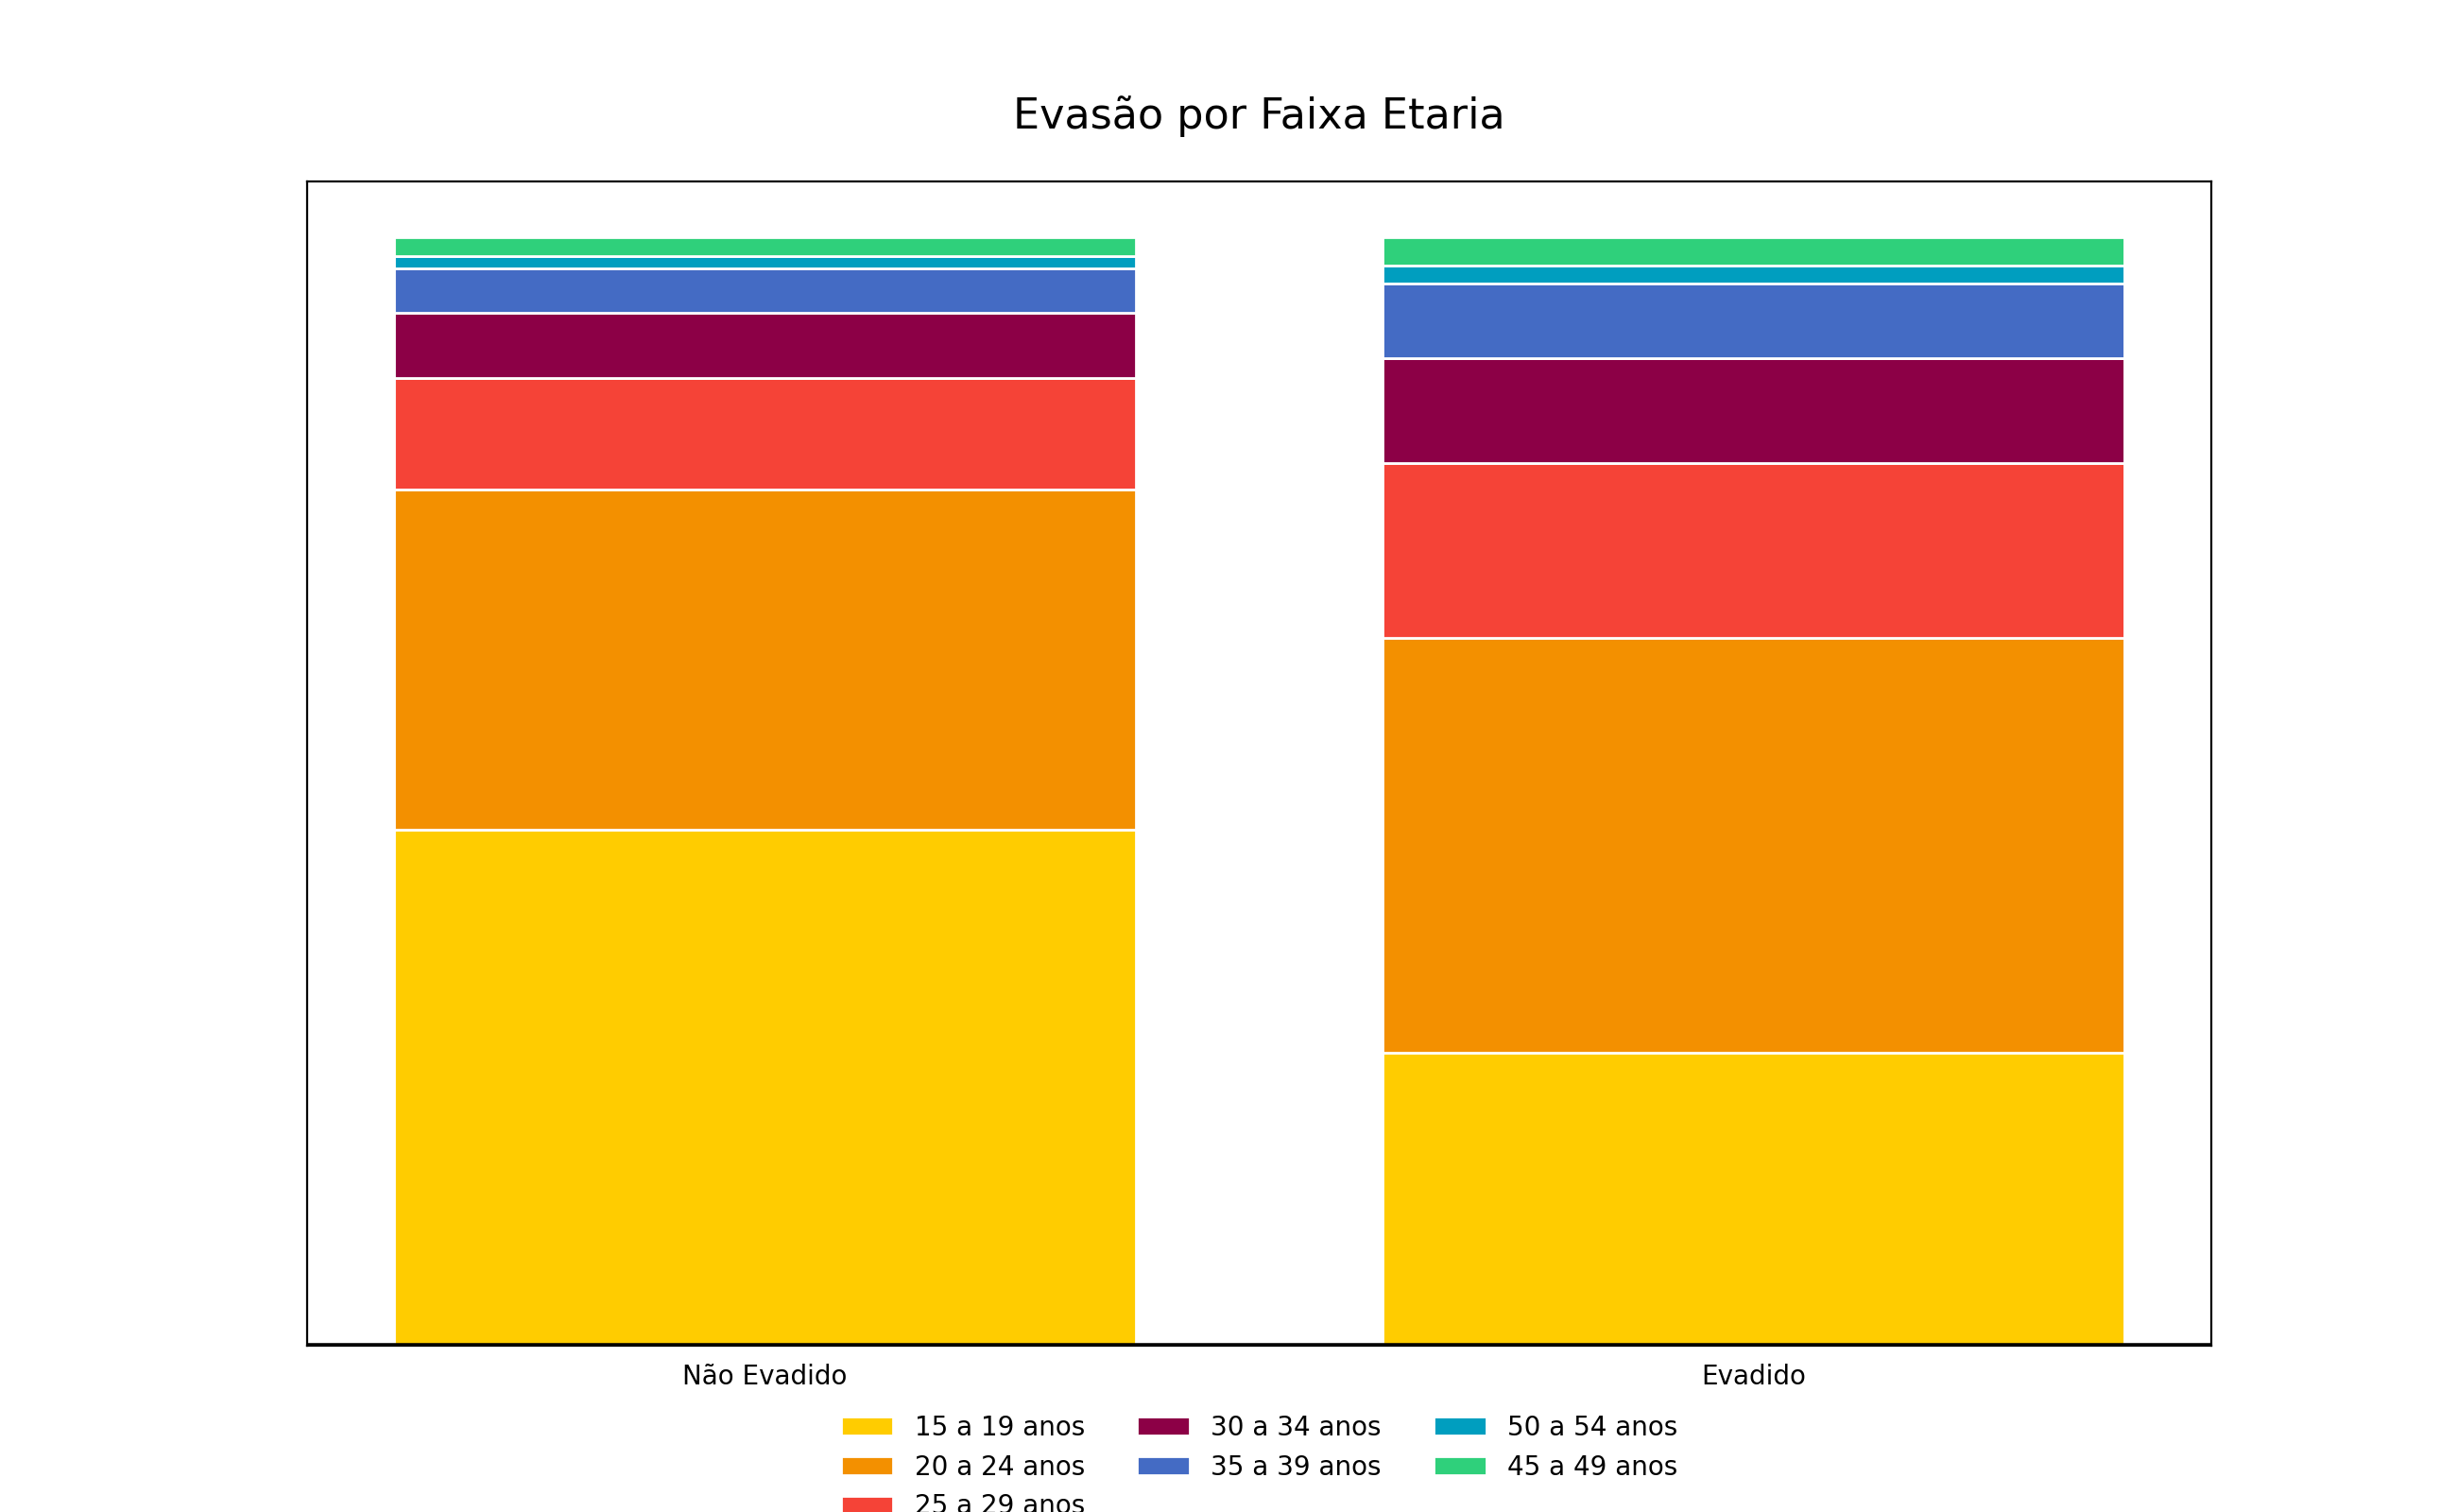

In [55]:
var1 = 'Evasao'
var2 = 'Faixa Etária'

ordem_linhas = ['Não Evadido', 'Evadido']
ordem_colunas = ['15 a 19 anos', '20 a 24 anos', '25 a 29 anos', '30 a 34 anos', '35 a 39 anos', '50 a 54 anos', '45 a 49 anos']

rank_Idade = analise_bi(df_filtered, var1, var2, ordem_linhas, ordem_colunas)
titulo = 'Evasão por Faixa Etaria'

barras_empilhadas_porcentagem(rank_Idade, titulo)

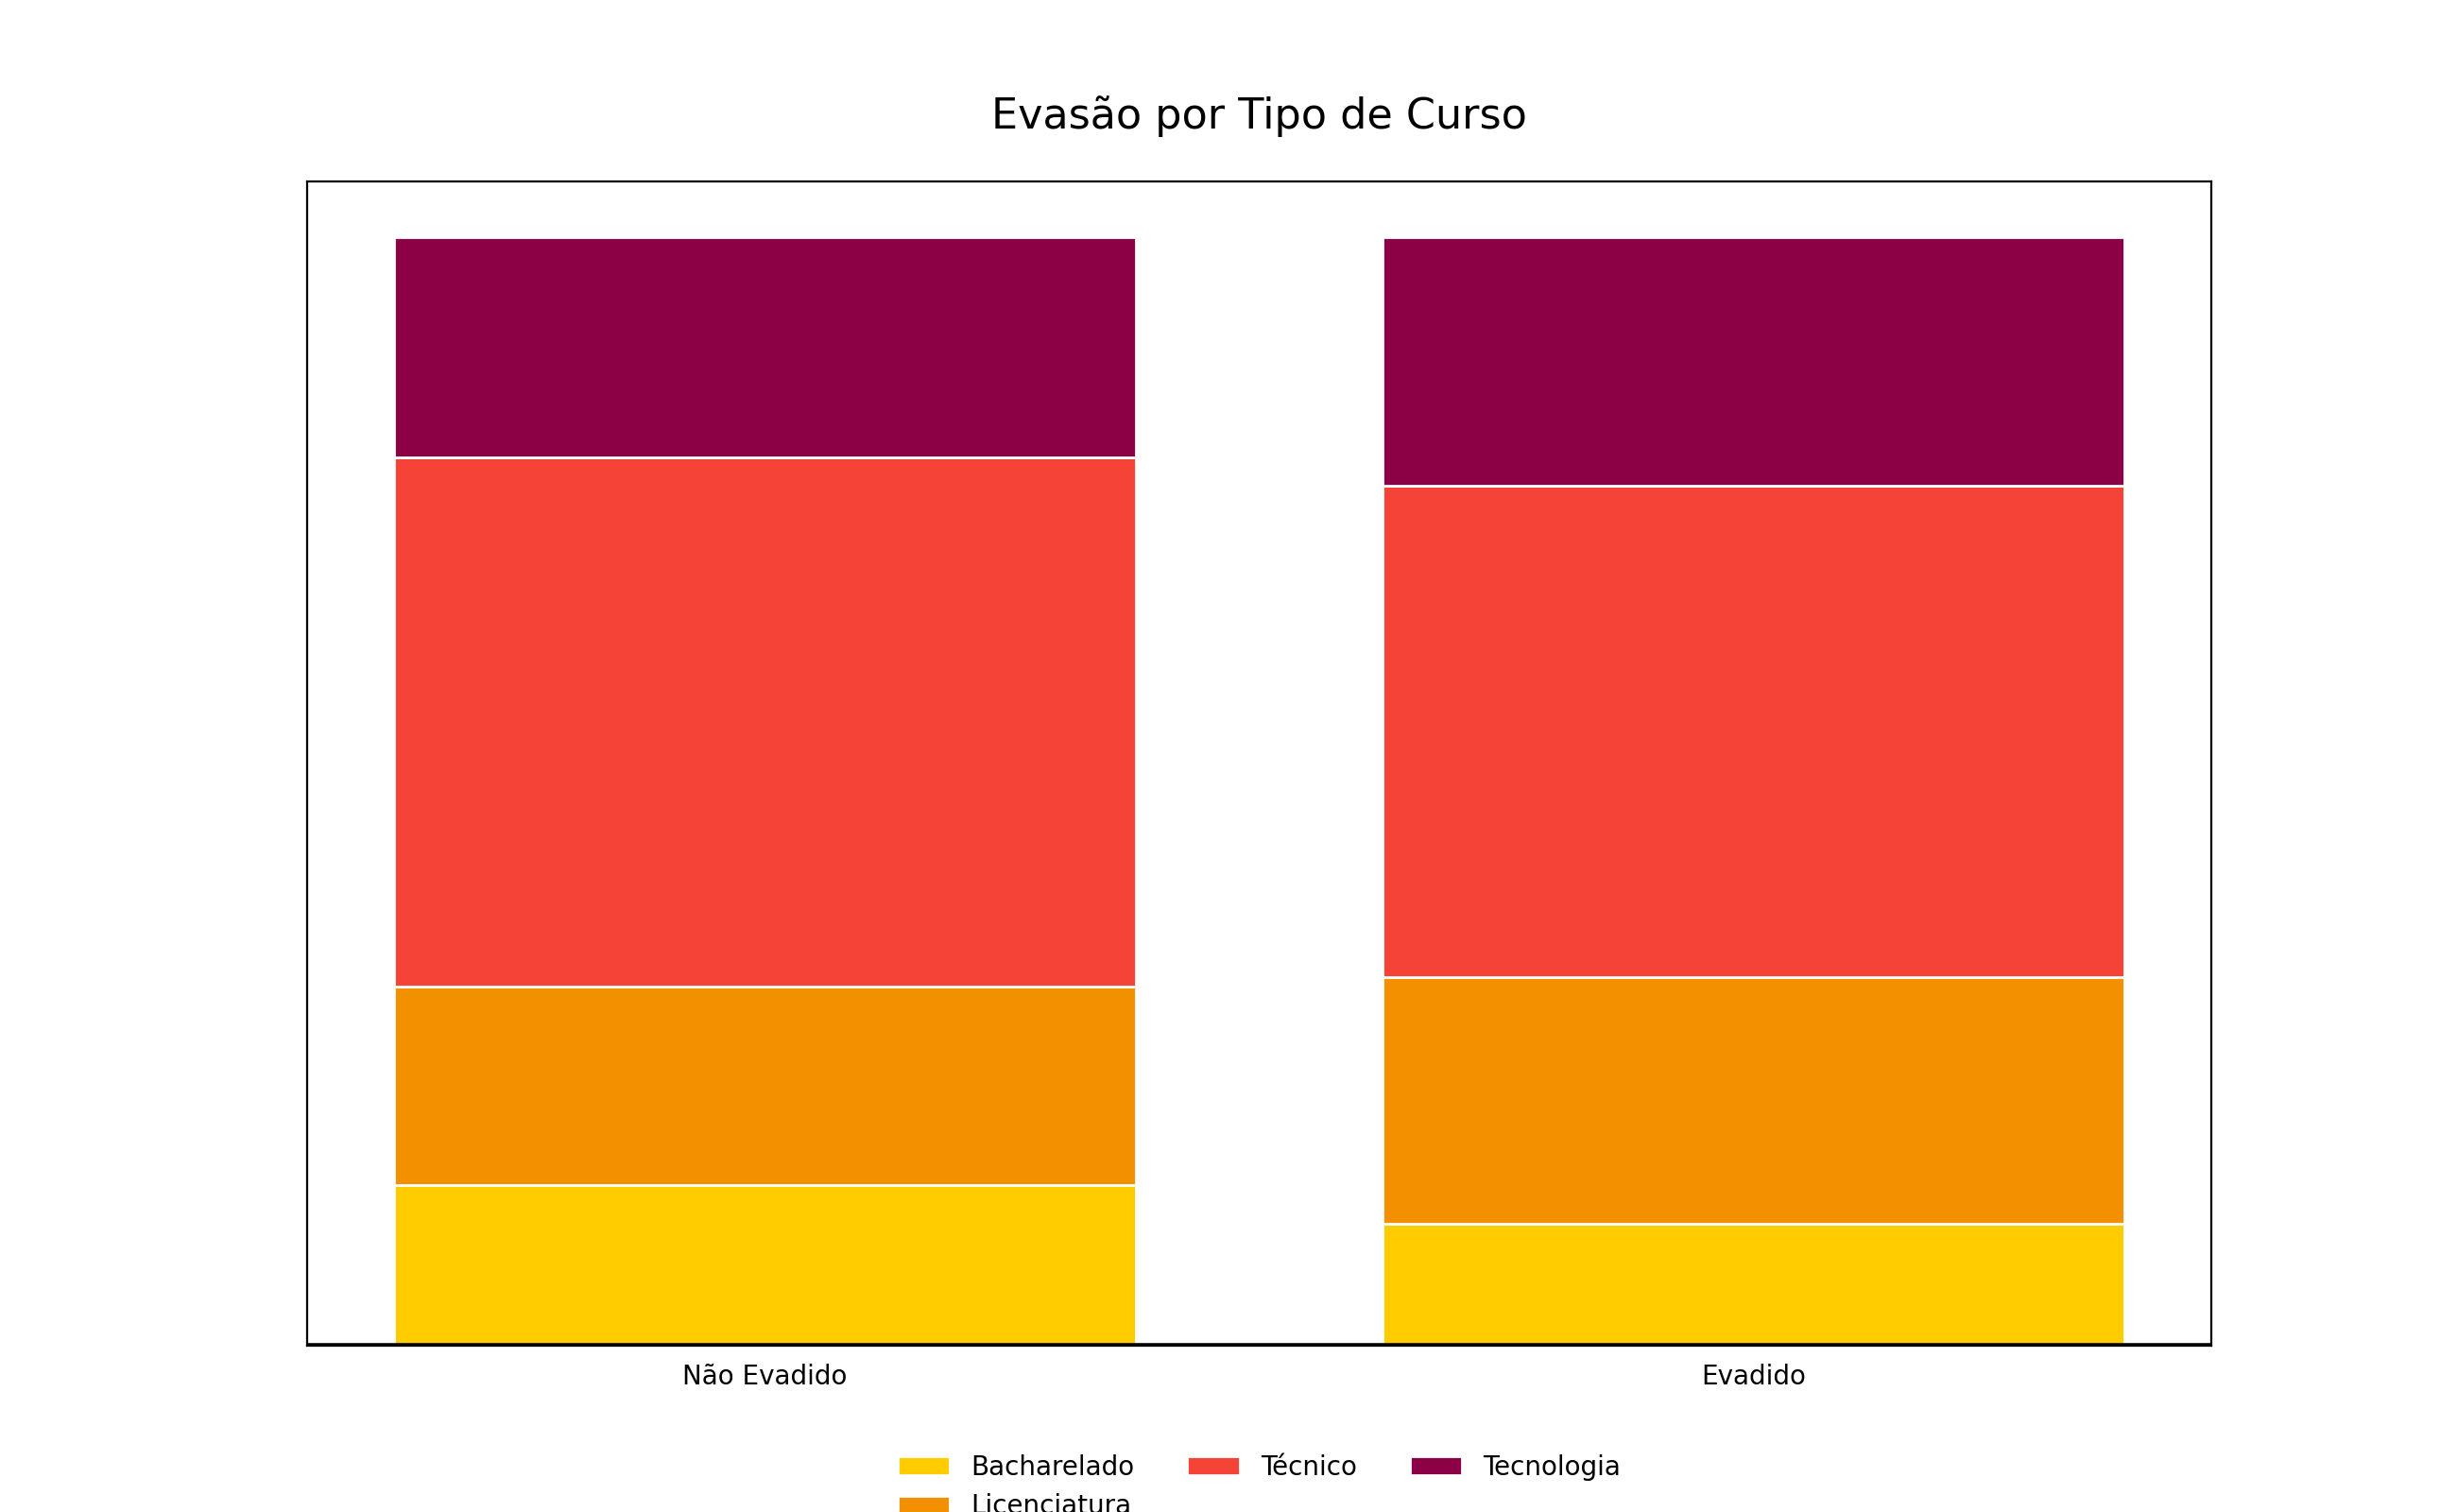

In [56]:
var1 = 'Evasao'
var2 = 'Tipo de Curso'

ordem_linhas = ['Não Evadido', 'Evadido']
ordem_colunas = ['Bacharelado', 'Licenciatura', 'Técnico', 'Tecnologia']

rank_Curso = analise_bi(df_filtered, var1, var2, ordem_linhas, ordem_colunas)
titulo = 'Evasão por Tipo de Curso'

barras_empilhadas_porcentagem(rank_Curso, titulo)

## **Referências Bibliográficas**

[1] PNP - Dados Abertos - MEC. Disponível em: <https://dadosabertos.mec.gov.br/pnp>. Acesso em: 14 jun. 2024.

[2] 2020 - Microdados Matrículas - Portal de Dados Abertos do Ministério da Educação. Disponível em: <https://dadosabertos.mec.gov.br/pnp/item/134-2020-microdados-matriculas>. Acesso em: 14 jun. 2024.
